# Prosper Loan Dataset : L'objectif est de prédire le défaut de remboursement d’un prêt.

### On commence avec l'importation de libraries

In [149]:
# Data Analysis libs : 
import pandas as pd
import numpy as np
from statistics import mode


# Data Vis libs :
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


### On importe le dataset

In [150]:
df = pd.read_csv("prosperLoanData.csv")

#### Ce jeu de données provient de la société de prêts Prosper. Il regroupe 113 937 prêts décrits par 81 variables

In [151]:
df.shape

(113937, 81)

In [152]:
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,NaN,NaN,NaN,NaN,NaN,NaN,0,CO,Other,Self-employed,2.0,True,True,NaN,2007-08-26 18:41:46.780000000,640.0,659.0,2001-10-11 00:00:00,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,E33A3400205839220442E84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,78,19141,9425,2007-09-12 00:00:00,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,A,7.0,2,CO,Professional,Employed,44.0,False,False,NaN,2014-02-27 08:28:14,680.0,699.0,1996-03-18 00:00:00,14.0,14.0,29.0,13,389.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,3989.0,0.21,10266.0,29.0,1.00,2.0,0.18,"$50,000-74,999",True,6125.000000,9E3B37071505919926B1D82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,134815,10000,2014-03-03 00:00:00,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,NaN,NaN,NaN,NaN,NaN,NaN,0,GA,Other,Not available,NaN,False,True,783C3371218786870A73D20,2007-01-02 14:09:10.060000000,480.0,499.0,2002-07-27 00:00:00,NaN,NaN,3.0,0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,Not displayed,True,2083.333333,6954337960046817851BCB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,86,6466,3001,2007-01-17 00:00:00,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,A,9.0,16,GA,Skilled Labor,Employed,113.0,True,False,NaN,2012-10-22 11:02:32,800.0,819.0,1983-02-28 00:00:00,5.0,5.0,29.0,7,115.0,0.0,1.0,4.0,10056.0,14.0,0.0,0.0,1444.0,0.04,30754.0,26.0,0.76,0.0,0.15,"$25,000-49,999",True,2875.000000,A0393664465886295619C51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,16,77296,10000,2012-11-01 00:00:00,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,3.0,D,4.0,2,MN

## Defition de la variable cible : la variablale cible est "LoanStatus", qui indique le statut du prêt.


In [153]:
df["LoanStatus"].unique()

array(['Completed', 'Current', 'Past Due (1-15 days)', 'Defaulted',
       'Chargedoff', 'Past Due (16-30 days)', 'Cancelled',
       'Past Due (61-90 days)', 'Past Due (31-60 days)',
       'Past Due (91-120 days)', 'FinalPaymentInProgress',
       'Past Due (>120 days)'], dtype=object)

### On va se concentrer sur les prêts sains et les prêts en défaut

 On crée la variable **LoanStatusBinaire** afin de définir la variable cible au format binaire, qui sera celle à prédire lors de la modélisation

In [154]:
# On essayera de prédire si un prêt sera remboursé ou non.
df = df[df["LoanStatus"].isin(['Completed', 'Current', 'Defaulted',
       'Chargedoff', 'Past Due (61-90 days)', 'Past Due (31-60 days)',
       'Past Due (91-120 days)', 'FinalPaymentInProgress',
       'Past Due (>120 days)'])]

We do note treat variables as Cancelled, Past Due 1-30 days as these variables do not show the default. For 1 month period an individual could forgot to pay, these variables are not representative enough. 

In [155]:
df["LoanStatusBinaire"] = df["LoanStatus"].apply(lambda x: 0 if x in ['Completed', 'Current','FinalPaymentInProgress'] else 1)

In [156]:
#Remarque Amel : Pourquoi inclure 'Current' alors que ce sont des profils à prévoir. Les currents pourront peut -être faire parti des défauts. 

## Duplicates Check

In [157]:
df[df.duplicated(keep=False)].shape 

(0, 82)

- No duplicates found

## Exploration des valeurs manquantes

Nous calculons la proportion de valeurs manquantes pour chaque colonne. Cela guidera nos décisions :


- Les colonnes présentant un taux de valeurs manquantes très élevé ( > 20 %) ne sont généralement pas utiles pour la modélisation et peuvent introduire un biais dans les résultats.

In [158]:
# Pourcentage de valeurs manquantes par colonne
missing_ratio = df.isna().mean().sort_values(ascending=False)

# Afficher les colonnes ayant le plus de valeurs manquantes
missing_ratio

GroupKey                               0.882014
LoanFirstDefaultedCycleNumber          0.849824
ScorexChangeAtTimeOfListing            0.834947
TotalProsperPaymentsBilled             0.807179
ProsperPaymentsOneMonthPlusLate        0.807179
ProsperPaymentsLessThanOneMonthLate    0.807179
ProsperPrincipalOutstanding            0.807179
ProsperPrincipalBorrowed               0.807179
TotalProsperLoans                      0.807179
OnTimeProsperPayments                  0.807179
CreditGrade                            0.743508
ClosedDate                             0.511931
EstimatedEffectiveYield                0.257653
EstimatedLoss                          0.257653
EstimatedReturn                        0.257653
ProsperRating (numeric)                0.257653
ProsperRating (Alpha)                  0.257653
ProsperScore                           0.257653
DebtToIncomeRatio                      0.074844
EmploymentStatusDuration               0.067526
AmountDelinquent                       0

#### Supprimer les colonnes avec un taux de valeurs manquantes très élevé (> 20%)


In [159]:
missing_procentage = 0.2
high_missing_cols = missing_ratio[missing_ratio > missing_procentage].index
print(f"Columns with > {missing_procentage*100:.0f}% missing values:")
print(high_missing_cols)

# Supprimer les colonnes avec un taux de valeurs manquantes très élevé
df = df.drop(columns=high_missing_cols)
print(f"Shape after dropping high-missing columns: {df.shape}")

Columns with > 20% missing values:
Index(['GroupKey', 'LoanFirstDefaultedCycleNumber',
       'ScorexChangeAtTimeOfListing', 'TotalProsperPaymentsBilled',
       'ProsperPaymentsOneMonthPlusLate',
       'ProsperPaymentsLessThanOneMonthLate', 'ProsperPrincipalOutstanding',
       'ProsperPrincipalBorrowed', 'TotalProsperLoans',
       'OnTimeProsperPayments', 'CreditGrade', 'ClosedDate',
       'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn',
       'ProsperRating (numeric)', 'ProsperRating (Alpha)', 'ProsperScore'],
      dtype='object')
Shape after dropping high-missing columns: (112861, 64)


## Suppression des identifiants ou colonnes techniques évidents

Certaines variables sont des identifiants ou des clés (par exemple, des identifiants internes). Elles ne contiennent pas d'information pertinente pour la prédiction de la cible et peuvent aussi introduire des fuites d'information.

In [160]:
df.columns

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'Term',
       'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'ListingCategory (numeric)', 'BorrowerState', 'Occupation',
       'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner',
       'CurrentlyInGroup', 'DateCreditPulled', 'CreditScoreRangeLower',
       'CreditScoreRangeUpper', 'FirstRecordedCreditLine',
       'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years',
       'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
       'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies',
       'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'TotalTrades',
       'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months',
       'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable',
       'StatedMo

In [161]:
id_columns = ['ListingKey', 'ListingNumber', 'LoanKey', 'LoanNumber', 'MemberKey']
df = df.drop(columns=id_columns)

In [162]:
df.shape

(112861, 59)

- Eventually, we dropped 22 variables which missing rate is more than 20%.

## Transformation des variables dates

On peut constater que les variables contenant des dates ne sont pas dans le bon format : elles sont de type object. Il est donc nécessaire de les convertir en type date

In [163]:
list_dates = ['ListingCreationDate', 'LoanOriginationDate', 'FirstRecordedCreditLine']
for col in list_dates:
    print("La variable ", col, "a pour format :", df[col].dtype)

La variable  ListingCreationDate a pour format : object
La variable  LoanOriginationDate a pour format : object
La variable  FirstRecordedCreditLine a pour format : object


In [164]:
for col in list_dates:
    df[col]= pd.to_datetime(df[col], errors='coerce')

La variable DateCreditPulled présentait des formats de dates mixtes ; on a donc nettoyé les micro/nanosecondes pour permettre à Pandas de la convertir correctement en datetime

In [165]:
df["DateCreditPulled"] = (
    df["DateCreditPulled"]
    .astype(str)
    .str.replace(r"\.\d{6,9}$", "", regex=True)  # remove micro/nanoseconds
)

df["DateCreditPulled"] = pd.to_datetime(
    df["DateCreditPulled"], 
    errors="coerce"
)

In [166]:
df["DateCreditPulled"].head()

0   2007-08-26 18:41:46
1   2014-02-27 08:28:14
2   2007-01-02 14:09:10
3   2012-10-22 11:02:32
4   2013-09-14 18:38:44
Name: DateCreditPulled, dtype: datetime64[ns]

On a converti la variable **LoanOriginationQuarter** en une vraie date en utilisant le début de chaque trimestre, afin de pouvoir l’utiliser correctement dans les analyses temporelles. On a séparé le trimestre et l’année pour reformer un format que Pandas peut comprendre (‘AAAAQx’), puis on  l’a converti en date représentant le début de chaque trimestr

In [167]:
tmp = df["LoanOriginationQuarter"].str.split(" ", expand=True)

df["LoanOriginationQuarter"] = (
    tmp[1] + "Q" + tmp[0].str[1]
).astype("period[Q]").dt.to_timestamp()

# EDA

This part is dedicated to the Exploratory Analysis of the dataset. 

In [168]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112861 entries, 0 to 113936
Data columns (total 59 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   ListingCreationDate                 112474 non-null  datetime64[ns]
 1   Term                                112861 non-null  int64         
 2   LoanStatus                          112861 non-null  object        
 3   BorrowerAPR                         112836 non-null  float64       
 4   BorrowerRate                        112861 non-null  float64       
 5   LenderYield                         112861 non-null  float64       
 6   ListingCategory (numeric)           112861 non-null  int64         
 7   BorrowerState                       107349 non-null  object        
 8   Occupation                          109285 non-null  object        
 9   EmploymentStatus                    110609 non-null  object        
 10  EmploymentSta

## Duplicate Values

In [170]:
df.duplicated().sum()

865

As we checked before, no duplicates were detected (before deleting LidtingKey). So these are not duplicates but the same data for different individuals (Listing Keys). No need to treate these rows.

## Missing Values (NaN)

In [171]:
df.isnull().sum()

ListingCreationDate                    387
Term                                     0
LoanStatus                               0
BorrowerAPR                             25
BorrowerRate                             0
LenderYield                              0
ListingCategory (numeric)                0
BorrowerState                         5512
Occupation                            3576
EmploymentStatus                      2252
EmploymentStatusDuration              7621
IsBorrowerHomeowner                      0
CurrentlyInGroup                         0
DateCreditPulled                         0
CreditScoreRangeLower                  590
CreditScoreRangeUpper                  590
FirstRecordedCreditLine                696
CurrentCreditLines                    7600
OpenCreditLines                       7600
TotalCreditLinespast7years             696
OpenRevolvingAccounts                    0
OpenRevolvingMonthlyPayment              0
InquiriesLast6Months                   696
TotalInquir

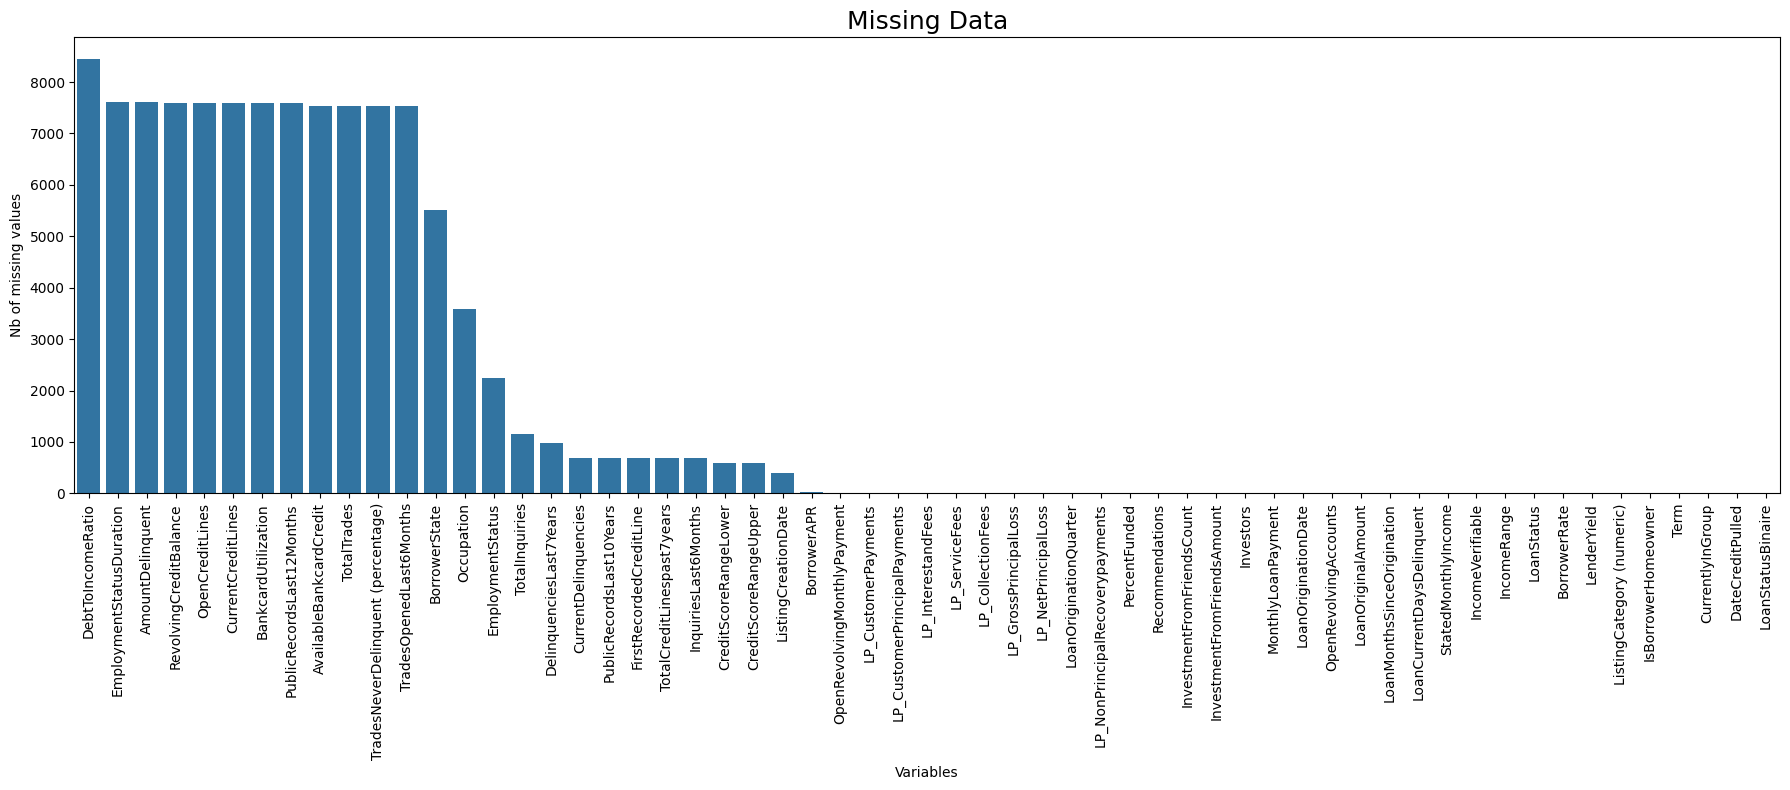

In [172]:
# Visualizing the missing values
missing_data = df.isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(18, 8))
ax = sns.barplot(x=missing_data.index, y=missing_data.values)

plt.xticks(rotation=90)
plt.title("Missing Data", fontsize=18)
plt.xlabel("Variables")
plt.ylabel("Nb of missing values")

plt.tight_layout()
plt.show()

In [173]:
cols_with_nan = df.columns[df.isna().any()].tolist()
nb_cols_with_nan = len(df.columns[df.isna().any()].tolist())

print(nb_cols_with_nan)

26


We observe that there are 26 columns that contain missing values. We are not going to impute them right now, the univaraite & bivariate analysis are the first step to analyze the importance of these varaibles.

# Check Unique Values for Each Varaible

In [174]:
for column in df.columns:
    print(f"{column} : {len(df[column].unique())}")

for c in df.columns:
    print(c)

ListingCreationDate : 111613
Term : 3
LoanStatus : 9
BorrowerAPR : 6676
BorrowerRate : 2294
LenderYield : 2283
ListingCategory (numeric) : 21
BorrowerState : 52
Occupation : 68
EmploymentStatus : 9
EmploymentStatusDuration : 606
IsBorrowerHomeowner : 2
CurrentlyInGroup : 2
DateCreditPulled : 111919
CreditScoreRangeLower : 27
CreditScoreRangeUpper : 27
FirstRecordedCreditLine : 11563
CurrentCreditLines : 55
OpenCreditLines : 53
TotalCreditLinespast7years : 119
OpenRevolvingAccounts : 48
OpenRevolvingMonthlyPayment : 2828
InquiriesLast6Months : 51
TotalInquiries : 103
CurrentDelinquencies : 48
AmountDelinquent : 7005
DelinquenciesLast7Years : 101
PublicRecordsLast10Years : 26
PublicRecordsLast12Months : 8
RevolvingCreditBalance : 38392
BankcardUtilization : 202
AvailableBankcardCredit : 31731
TotalTrades : 109
TradesNeverDelinquent (percentage) : 99
TradesOpenedLast6Months : 20
DebtToIncomeRatio : 1201
IncomeRange : 8
IncomeVerifiable : 2
StatedMonthlyIncome : 13421
LoanCurrentDaysDelinq

At this step it is important to understand variables. 

- Binary columns : 'IsBorrowerHomeowner', 'CurrentlyInGroup', 'IncomeVerifiable', 'LoanStatusBinaire'

- Small category columns (3–10 unique): 'Term', 'LoanStatus', 'EmploymentStatus', 'PublicRecordsLast12Months', 'IncomeRange'

- Medium category columns (11–50 unique): 'ListingCategory (numeric)', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'OpenRevolvingAccounts', 'InquiriesLast6Months', 'CurrentDelinquencies', 'PublicRecordsLast10Years', 'TradesOpenedLast6Months', 'LoanOriginationQuarter', 'Recommendations', 'InvestmentFromFriendsCount'

- High unique columns (51–200 unique): 'BorrowerState', 'Occupation', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'TotalInquiries', 'DelinquenciesLast7Years', 'TotalTrades', 'TradesNeverDelinquent (percentage)', 'LoanMonthsSinceOrigination'

- Very high unique columns (>200): 'ListingCreationDate', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EmploymentStatusDuration', 'DateCreditPulled', 'FirstRecordedCreditLine', 'OpenRevolvingMonthlyPayment', 'AmountDelinquent', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'LoanCurrentDaysDelinquent', 'LoanNumber', 'LoanOriginalAmount', 'LoanOriginationDate', 'MonthlyLoanPayment', 'LP_CustomerPayments', 'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees', 'LP_CollectionFees', 'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss', 'LP_NonPrincipalRecoverypayments', 'PercentFunded', 'InvestmentFromFriendsAmount', 'Investors'

## Data Wrangling

### Identification of Numerical & Categorical Variables

In [175]:
cols_categoricals = []
cols_numericals = []
cols_dates = []

for col in df.columns:
    if pd.api.types.is_datetime64_any_dtype(df[col]):
        cols_dates.append(col)
    elif df[col].dtype == "object":
        cols_categoricals.append(col)
    else:
        cols_numericals.append(col)

print(f"Dates: {cols_dates} \nNumericals: {cols_numericals} \nCategoricals: {cols_categoricals}")


Dates: ['ListingCreationDate', 'DateCreditPulled', 'FirstRecordedCreditLine', 'LoanOriginationDate', 'LoanOriginationQuarter'] 
Numericals: ['Term', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'ListingCategory (numeric)', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CurrentlyInGroup', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'IncomeVerifiable', 'StatedMonthlyIncome', 'LoanCurrentDaysDelinquent', 'LoanMonthsSinceOrigination', 'LoanOriginalAmount', 'MonthlyLoanPayment', 'LP_CustomerPayments', 'LP_Customer

Lets analyse the output. 

### Dates : 
- 'LoanOriginationQuarter': The quarter in which the loan was originated. We transformed this variable to date format in cleaning phase.

### Categoricals :  
- 'IsBorrowerHomeowner': A Borrower will be classified as a homowner if they have a mortgage on their credit profile or provide documentation confirming they are a homeowner. 
- 'CurrentlyInGroup': Specifies whether or not the Borrower was in a group at the time the listing was created.
- 'IncomeVerifiable': The borrower indicated they have the required documentation to support their income.
- 'LoanStatusBinaire': Specifies whether a loan is healthy (0) or problematic/defaulted (1).
These variables are actually binar (cf. unique values) so they should be added from numercials to categoricals. 

### Numericals :
- binary variables should be excluded.
- leakage variables should be excluded.


### Leakage Variables : 
- 'LP_CustomerPayments': **Pre charge-off** cumulative gross payments made by the borrower on the loan. If the loan has charged off, this value will exclude any recoveries. 
- 'LP_CustomerPrincipalPayments': **Pre charge-off** cumulative principal payments made by the borrower on the loan. If the loan has charged off, this value will exclude any recoveries.
- 'LP_InterestandFees': **Pre charge-off** cumulative interest and fees paid by the borrower. If the loan has charged off, this value will exclude any recoveries.
- 'LP_ServiceFees': Cumulative service fees paid by the **investors who have invested in the loan** (fees are accumulated only after the loan is issued and payments begin).
- 'LP_CollectionFees':  Cumulative collection fees paid by the **investors who have invested in the loan** (only when the borrower is already delinquent).
- 'LP_GrossPrincipalLoss': The gross **charged off** amount of the loan (A charge-off happens only after the loan has defaulted).
- 'LP_NetPrincipalLoss': The principal that remains **uncollected after any recoveries**.
- 'LP_NonPrincipalRecoverypayments': The interest and fee component of **any recovery payments**. The current payment policy applies payments in the following order: Fees, interest, principal.
- 'LoanCurrentDaysDelinquent': The number of **days delinquent**
.
Even though some descriptions do not explicitly mention future/after issuance, all these variables describe events that happen **after the loan is issued**, meaning they cannot be known at the moment of loan approval.

Data leakage is to a situation where information that should not be accessible to the ML model during training becomes part of the training dataset, this misleading information may impact model's performance. The model will perform well during testing because it has access to information it wouldn’t normally have at prediction time. These variables will be treated in the Feature Engineering part.

### Correction of Lists of Variables

This phase is mostly done "by hand" than pure coding, as the machine does not understand business logic and the true meaning of variables.

In [176]:
# Leakage variables should be dropped
leakage_vars = ['LP_CustomerPayments', 
                'LP_CustomerPrincipalPayments',
                'LP_InterestandFees',
                'LP_ServiceFees',
                'LP_CollectionFees',
                'LP_GrossPrincipalLoss',
                'LP_NetPrincipalLoss',
                'LP_NonPrincipalRecoverypayments',
                'LoanCurrentDaysDelinquent'
]


df = df.drop(columns=leakage_vars)
print(f"Shape after dropping leakage features : {df.shape}")

Shape after dropping leakage features : (112861, 50)


In [177]:
#Remarque Amel : A mettre dans la partie de Juan.

In [178]:
# Binary variables should be transfered to the categoricals
binary_variables = [
    'IsBorrowerHomeowner',
    'CurrentlyInGroup',
    'IncomeVerifiable',
    'LoanStatusBinaire'
]


cols_categoricals = cols_categoricals + binary_variables
print(f"Updated list of categorical variables: {cols_categoricals}")


Updated list of categorical variables: ['LoanStatus', 'BorrowerState', 'Occupation', 'EmploymentStatus', 'IncomeRange', 'IsBorrowerHomeowner', 'CurrentlyInGroup', 'IncomeVerifiable', 'LoanStatusBinaire']


In [179]:
# Numericals variables shoud be adjusted
cols_numericals = [col for col in cols_numericals if col not in binary_variables]
cols_numericals = [col for col in cols_numericals if col not in leakage_vars]
print(f"Updated list of numerical variables: {cols_numericals}")


Updated list of numerical variables: ['Term', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'ListingCategory (numeric)', 'EmploymentStatusDuration', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'LoanMonthsSinceOrigination', 'LoanOriginalAmount', 'MonthlyLoanPayment', 'PercentFunded', 'Recommendations', 'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount', 'Investors']


# Univariate Analysis

### Distribution of the numerical variables

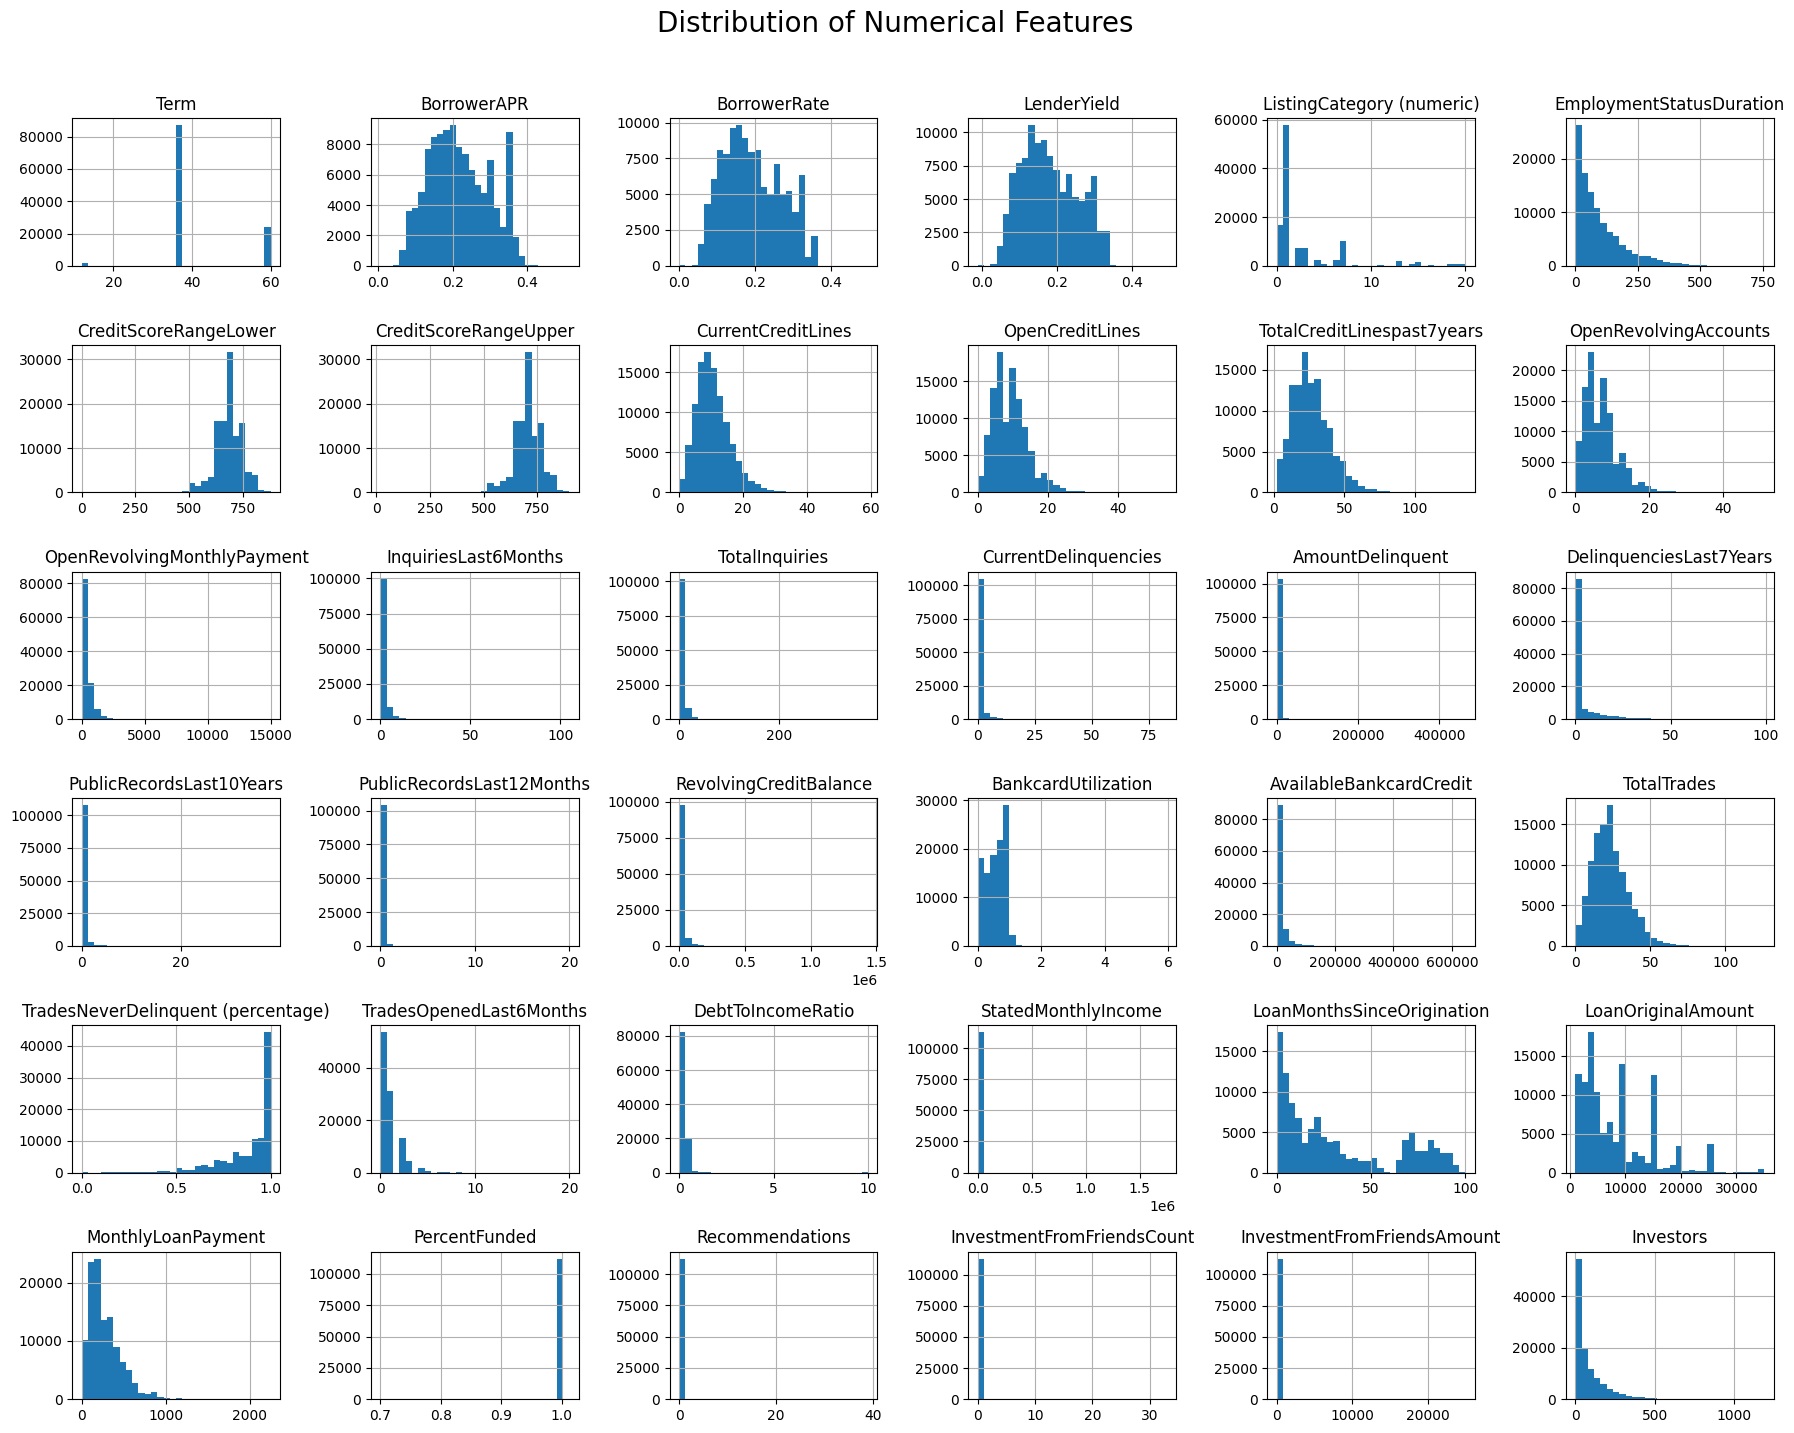

In [180]:
df[cols_numericals].hist(figsize=(18,14), bins=30)

plt.suptitle("Distribution of Numerical Features", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

#### Statistical Interpretation (A REVOIR)
**Right skewed distribution**

- OpenRevolvingMonthlyPayment
- RevolvingCreditBalance
- AvailableBankcardCredit
- AmountDelinquent
- StatedMonthlyIncome
- LoanOriginalAmount
- MonthlyLoanPayment
- Investors
- InvestmentFromFriendsAmount

These features contain long tails, so models like log regression, KNN, linear models will benefit from log-scaling, otherwise they are dominated by extreme values. We may need to apply log-transformation.

**Bimodal distribution**
- DebtToIncomeRatio 
- TradesNeverDelinquent (percentage) 
- Term 

These shapes commonly indicate heterogeneous segmentation: new borrowers vs experienced, low vs high credit quality, different loan contract types. We need to group or treat them separately.

**Variables with extreme outliers**
- InquiriesLast6Months
- TotalInquiries
- CurrentDelinquencies
- DelinquenciesLast7Years
- PublicRecordsLast10Years
- PublicRecordsLast12Months
- TradesOpenedLast6Months

**Variables with normal-like distribution**
- BorrowerAPR
- BorrowerRate
- LenderYield

**Variables with discrete counts (ok but skewed)**
- OpenCreditLines
- CurrentCreditLines
- TotalCreditLinespast7years

These are not continuous but count data, still moderately right-skewed.



## Correlation Matrix (heatmap)

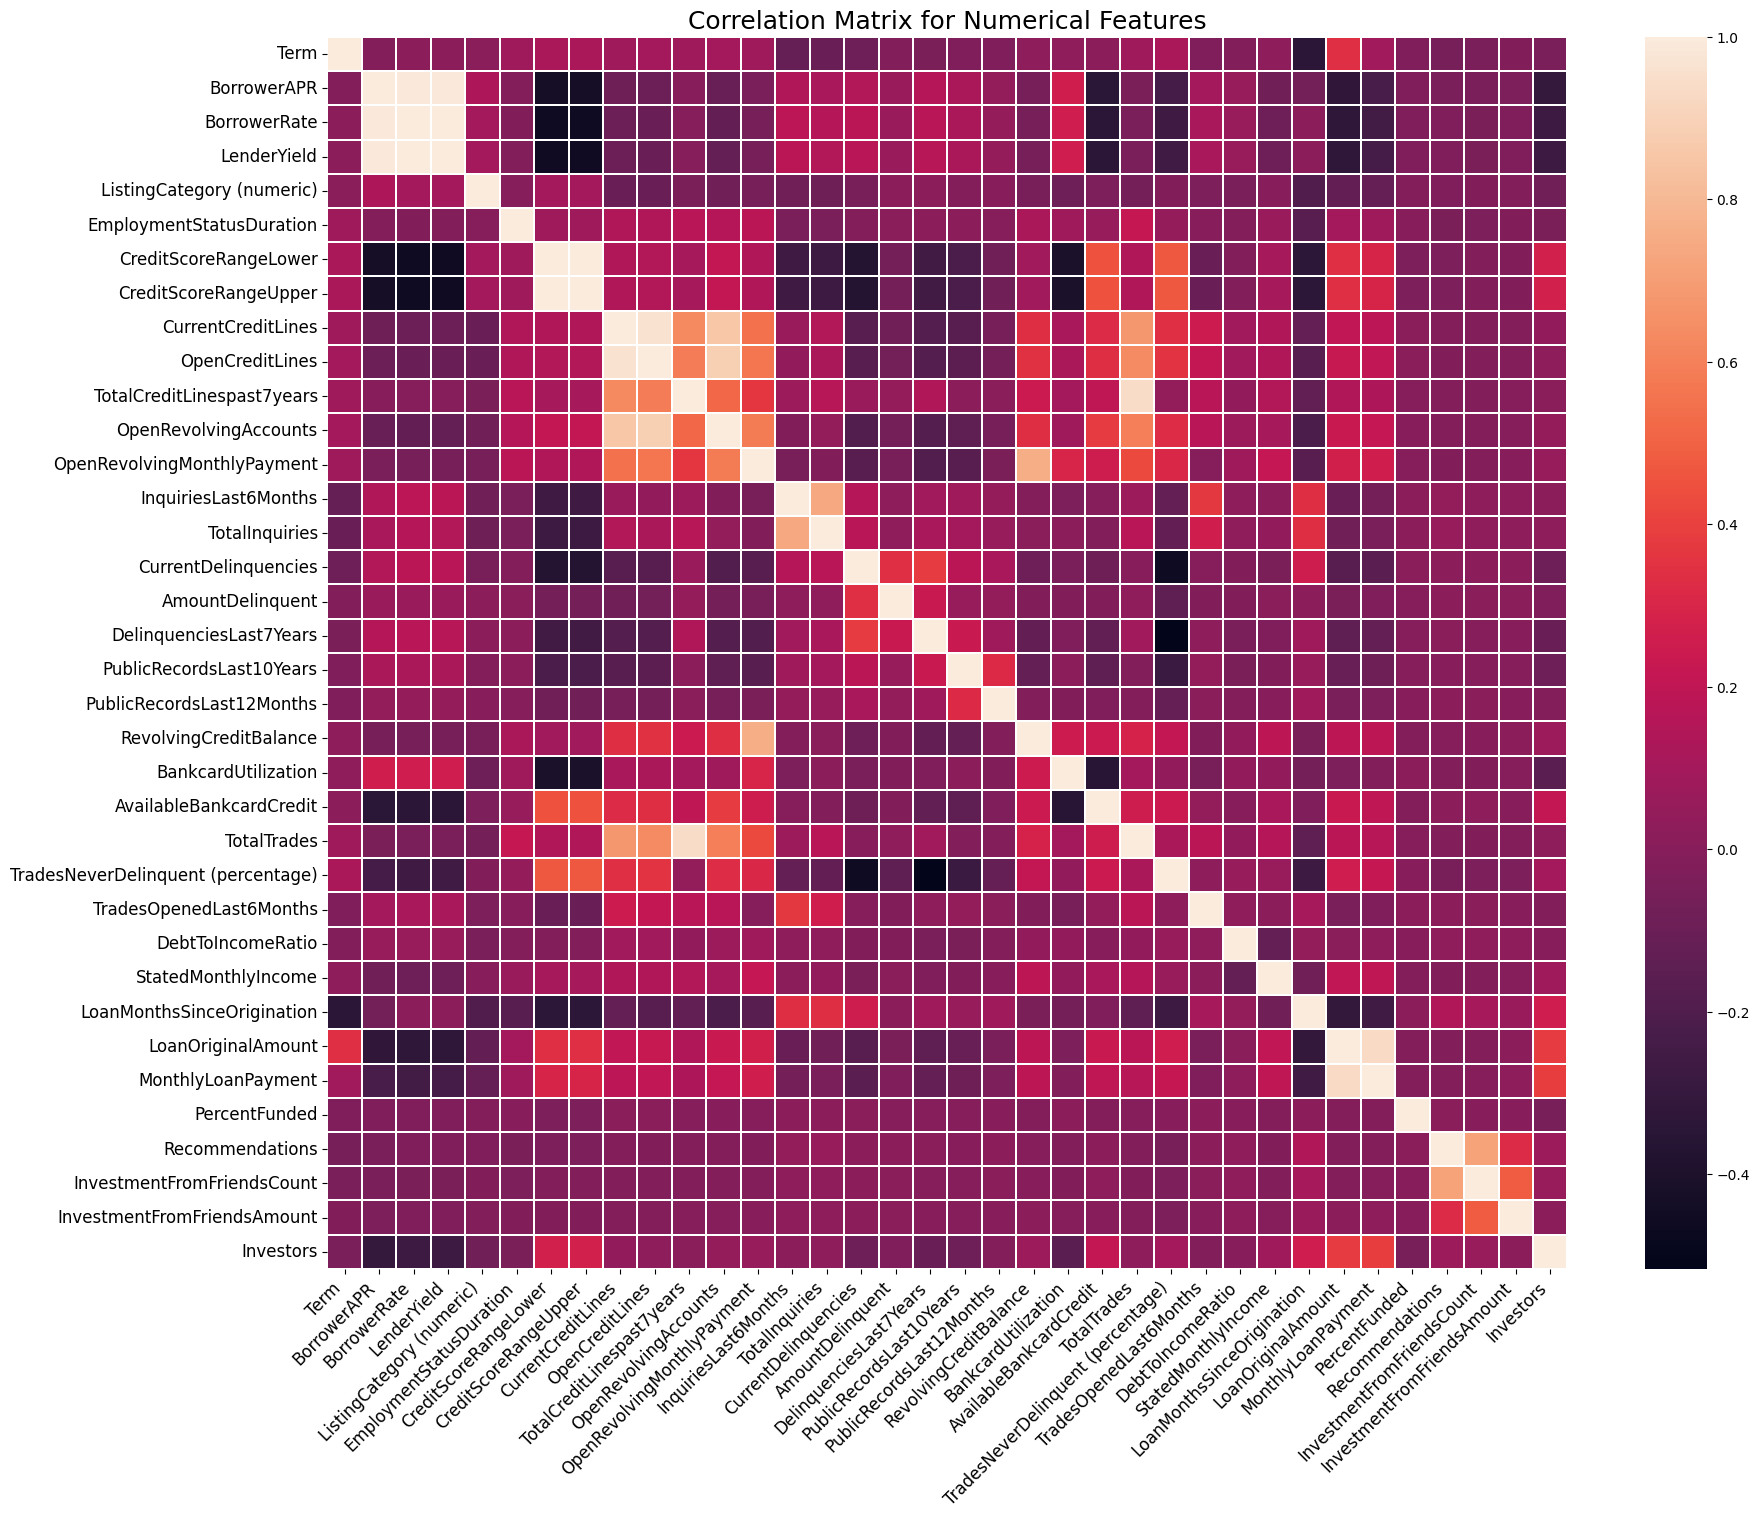

In [181]:
matrice_corr = df[cols_numericals].corr()

plt.figure(figsize=(20, 16))

sns.heatmap(matrice_corr, annot=False, linewidths=0.3)

plt.title("Correlation Matrix for Numerical Features", fontsize=18)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)
plt.show()


We observe that most cells are violet, proving no strong linear dependece between features. Despite this, the heatmap stays huge and complicated for precise analysis. We are going to highlight strong correlation. 

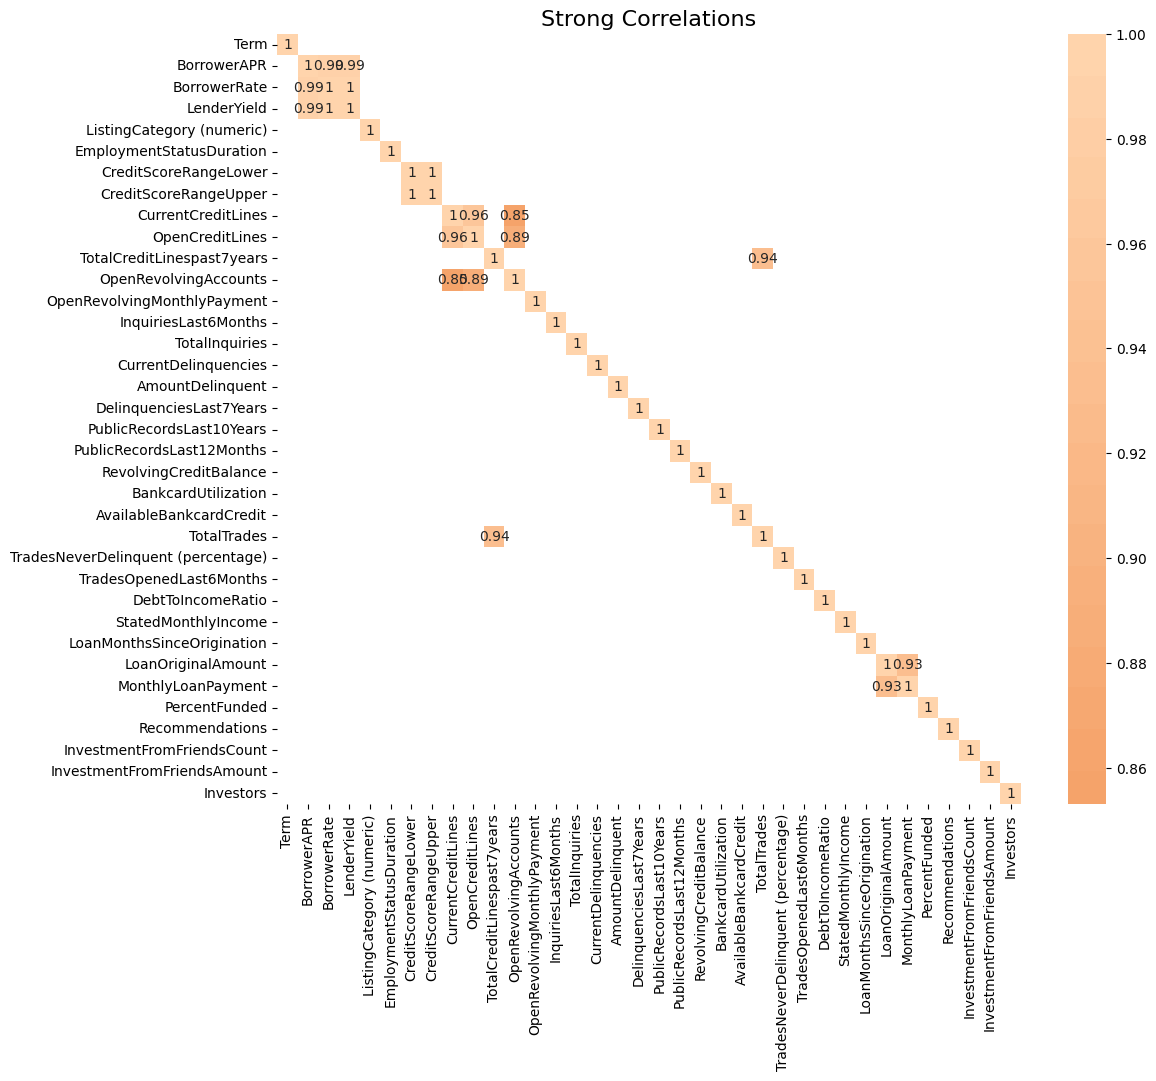

In [182]:
strong_positive_corr = matrice_corr[(matrice_corr.abs() > 0.8) & (matrice_corr.abs() <= 1.0)]
strong_positive_corr = strong_positive_corr.dropna(how="all", axis=0).dropna(how="all", axis=1)

plt.figure(figsize=(12,10))
sns.heatmap(strong_positive_corr, annot=True, center=0)
plt.title("Strong Correlations", fontsize=16)
plt.show()

#### Inverse Relationships

In [183]:
strong_negative_corr = matrice_corr.stack().loc[lambda x: x < -0.5]
strong_negative_corr

DelinquenciesLast7Years             TradesNeverDelinquent (percentage)   -0.516408
TradesNeverDelinquent (percentage)  DelinquenciesLast7Years              -0.516408
dtype: float64

No strong negative relations were detected (with correlation < -0.8), however : 
- DelinquenciesLast7Years: Number of delinquencies in the past 7 years at the time the credit profile was pulled.
- TradesNeverDelinquent: Number of trades that have never been delinquent at the time the credit profile was pulled.
this pair has a correlation of -0.5, which is logical, as more deliquences were detected, less the number of trades that have neber been delinauent.

#### Correlation Summary 

Eventually, we can highlit several groupes based on strong correlations : 
**Borrower rate related relations**
- BorrowerAPR: The Borrower's Annual Percentage Rate (APR) for the loan.
- BorrowerRate: The Borrower's interest rate for this loan.
- LenderYield: Lender yield is equal to the interest rate on the loan less the servicing fee.
These three features all represent the same consept of borrower rate (or interest rate). Keeping all three will create multicollinearity, one variable is sufficient.

**Credit Score ranges relations**
- CreditScoreRangeLower: The lower value representing the range of the borrower's credit score as provided by a consumer credit rating agency.
- CreditScoreRangeUpper: The upper value representing the range of the borrower's credit score as provided by a consumer credit rating agency.
The fateures shows the same range of borrower's credit score. 

**Credit lines relations**
- CurrentCreditLines: Number of current credit lines at the time the credit profile was pulled.
- OpenCreditLines: Number of open credit lines at the time the credit profile was pulled.
- OpenRevolvingAccount: Number of open revolving accounts at the time the credit profile was pulled.
These features describe the borrower’s credit activity. We may reduce dimensionality by selecting only one representative or using PCA (# AMEL TU EN PENSES QUOI ?)

**Number of lines related relations**
- TotalCreditLinespast7years: Number of credit lines in the past seven years at the time the credit profile was pulled.
- TotalTrades: Number of trade lines ever opened at the time the credit profile was pulled.
These variables show number of vredit lines by the different time.

**Loan Amount related relations**
- LoanOriginalAmount: The origination amount of the loan.
- MonthlyLoanPayment: The scheduled monthly loan payment.
The same loan amount calculated differently.

### Treating Strongly Correlated Variables 

The choice for removing correlated variables is simple: we keep the variable with the lowest number of missing values.

In [184]:
# for ranges we take the mean value
df["CreditScoreMean"] = (df["CreditScoreRangeLower"] + df["CreditScoreRangeUpper"]) / 2

In [185]:
correlated_variables_to_drop = ['BorrowerAPR', # 25 NaN
                                'LenderYield', # 0 NaN, although trees are not that sensible for the correlations, still this is the same rate calulated differently.
                                # keeping BorrowerRate has 0 NaN
                                
                                'CreditScoreRangeLower', # 0 NaN
                                'CreditScoreRangeUpper', # 0 NaN, for the ranges we will calculate the mean of them
                                # keeping their mean 

                                'CurrentCreditLines', # 7600 NaN
                                'OpenCreditLines', # 7600 NaN
                                # keeping OpenRevolvingAccount has 0 NaN

                                'TotalTrades', # 7540 NaN
                                # keeping TotalCreditLinespast7years 696 NaN

                                # Remarque AMEL , j'en ai besoin 'MonthlyLoanPayment' # 0 NaN
                                 'LoanOriginalAmount' # 0 NaN
                                ]

df = df.drop(columns=correlated_variables_to_drop)

In [186]:
df.shape

(112861, 43)

In [187]:
cols_numericals = [col for col in cols_numericals if col not in correlated_variables_to_drop]
print(cols_numericals)

['Term', 'BorrowerRate', 'ListingCategory (numeric)', 'EmploymentStatusDuration', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'LoanMonthsSinceOrigination', 'MonthlyLoanPayment', 'PercentFunded', 'Recommendations', 'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount', 'Investors']


### Distribution of the Borrower's interest rate

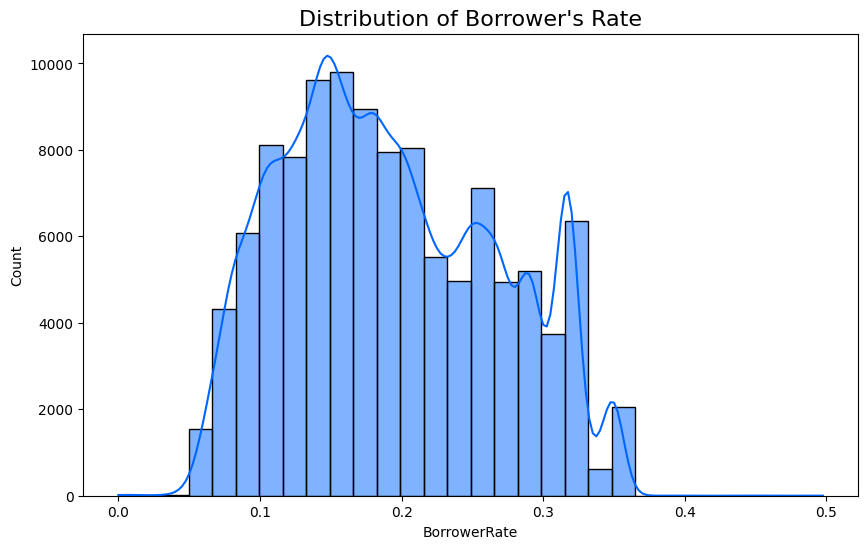

In [188]:
plt.figure(figsize=(10,6))
sns.histplot(df['BorrowerRate'], bins=30, kde=True, color="#0066FF")
plt.title("Distribution of Borrower's Rate", fontsize=16)
plt.xlabel("BorrowerRate")
plt.ylabel("Count")
plt.show()

The most significant spikes occur around the 0.1% and 0.2% interest rates. 
These peaks suggest that a large portion of the data points cluster at these rates and suggests a small spread of interest rates with concentrations at specific points.

### Skewness Check

In [189]:
df[cols_numericals].skew().sort_values(ascending=False)

StatedMonthlyIncome                   124.857462
InvestmentFromFriendsCount             43.472077
InvestmentFromFriendsAmount            34.648290
Recommendations                        31.705547
PublicRecordsLast12Months              30.885860
AmountDelinquent                       19.702701
DebtToIncomeRatio                      15.419064
RevolvingCreditBalance                  8.792845
CurrentDelinquencies                    8.128074
PublicRecordsLast10Years                7.992324
TotalInquiries                          7.023979
AvailableBankcardCredit                 5.908556
InquiriesLast6Months                    5.654589
DelinquenciesLast7Years                 4.006024
OpenRevolvingMonthlyPayment             3.783108
ListingCategory (numeric)               2.455721
TradesOpenedLast6Months                 2.268439
Investors                               2.134399
EmploymentStatusDuration                1.585498
MonthlyLoanPayment                      1.412191
OpenRevolvingAccount

- Skew > 1: right long tail, needs log-transformation
- Skew = 0: normal distribution (nearly symmetrical distribution)
- Skew < –1: left long tail needs log-transformation

#### Kurtosis Check

In [190]:
df[cols_numericals].kurt().sort_values(ascending=False)

StatedMonthlyIncome                   26696.056077
InvestmentFromFriendsCount             4449.675487
PublicRecordsLast12Months              2869.164287
Recommendations                        2449.913331
InvestmentFromFriendsAmount            1691.588179
AmountDelinquent                        658.109922
DebtToIncomeRatio                       260.602896
TotalInquiries                          226.272621
PublicRecordsLast10Years                202.640502
PercentFunded                           194.468822
RevolvingCreditBalance                  167.221196
CurrentDelinquencies                    135.424284
InquiriesLast6Months                     88.684993
AvailableBankcardCredit                  78.934691
OpenRevolvingMonthlyPayment              42.549332
DelinquenciesLast7Years                  21.270868
TradesOpenedLast6Months                  10.571338
Investors                                 6.041861
ListingCategory (numeric)                 5.900527
TradesNeverDelinquent (percenta

- Kurtosis > 3: heavy tails or a higher probability of extreme values
- Kurtosis = 0: nearly symetrical distribution
- Kurtosis < 3: thin tails & fewer values are close to the mean

## Distribution of Categoricals Variables

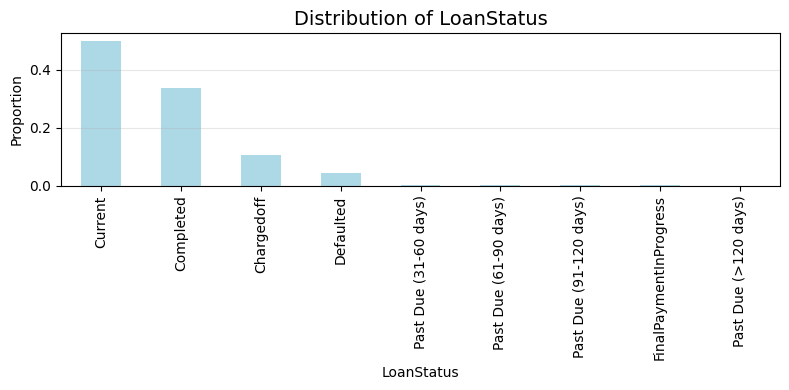

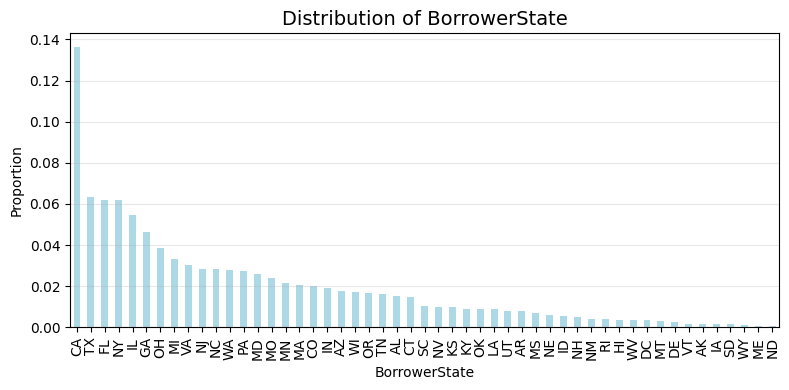

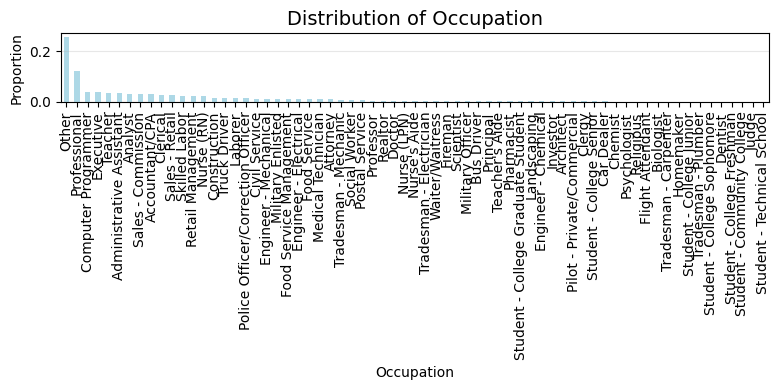

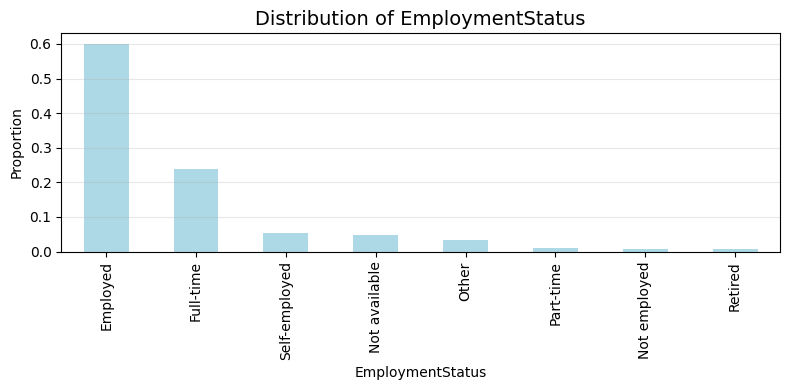

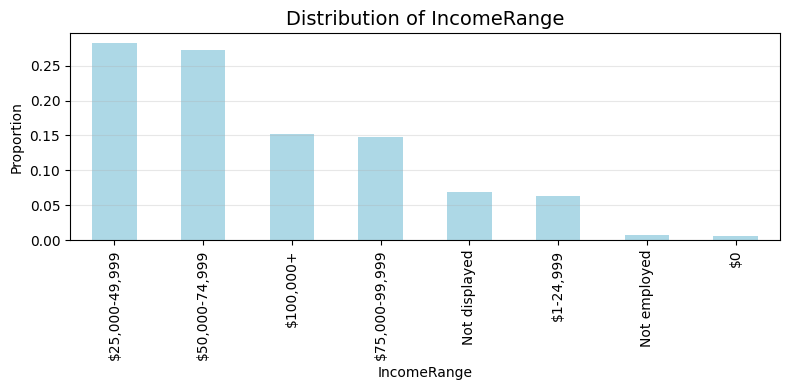

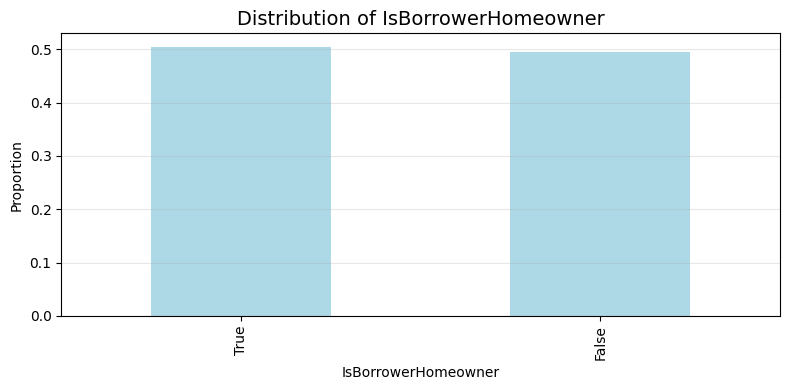

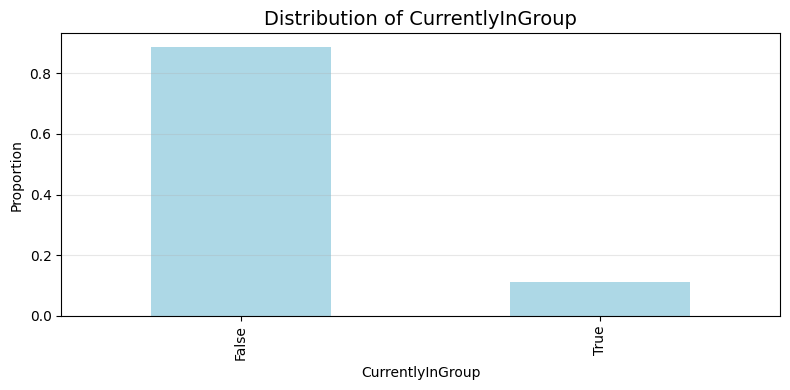

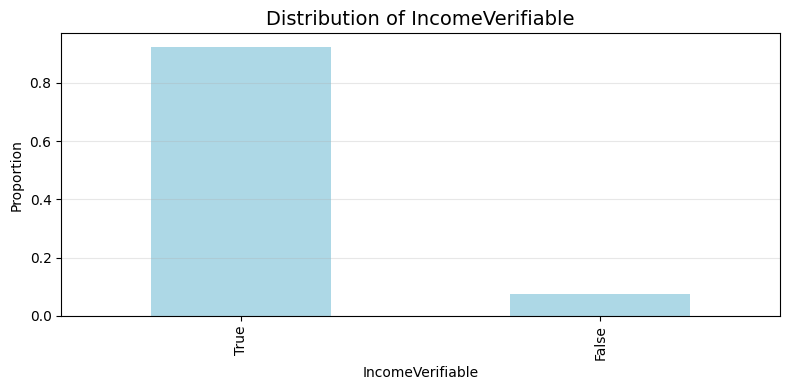

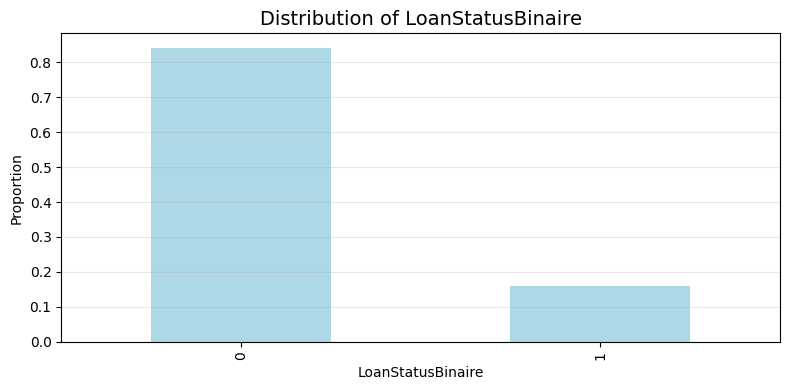

In [191]:
for col in cols_categoricals:
    plt.figure(figsize=(8, 4))
    
    df[col].value_counts(normalize=True).sort_values(ascending=False).plot(kind="bar", color="lightblue")
    
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Proportion")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [192]:
#Remarque Amel : Pour les variables avec bcp de modalités, voir si on creer des groupes pour équilibrer les modalités 

#### Boxplots

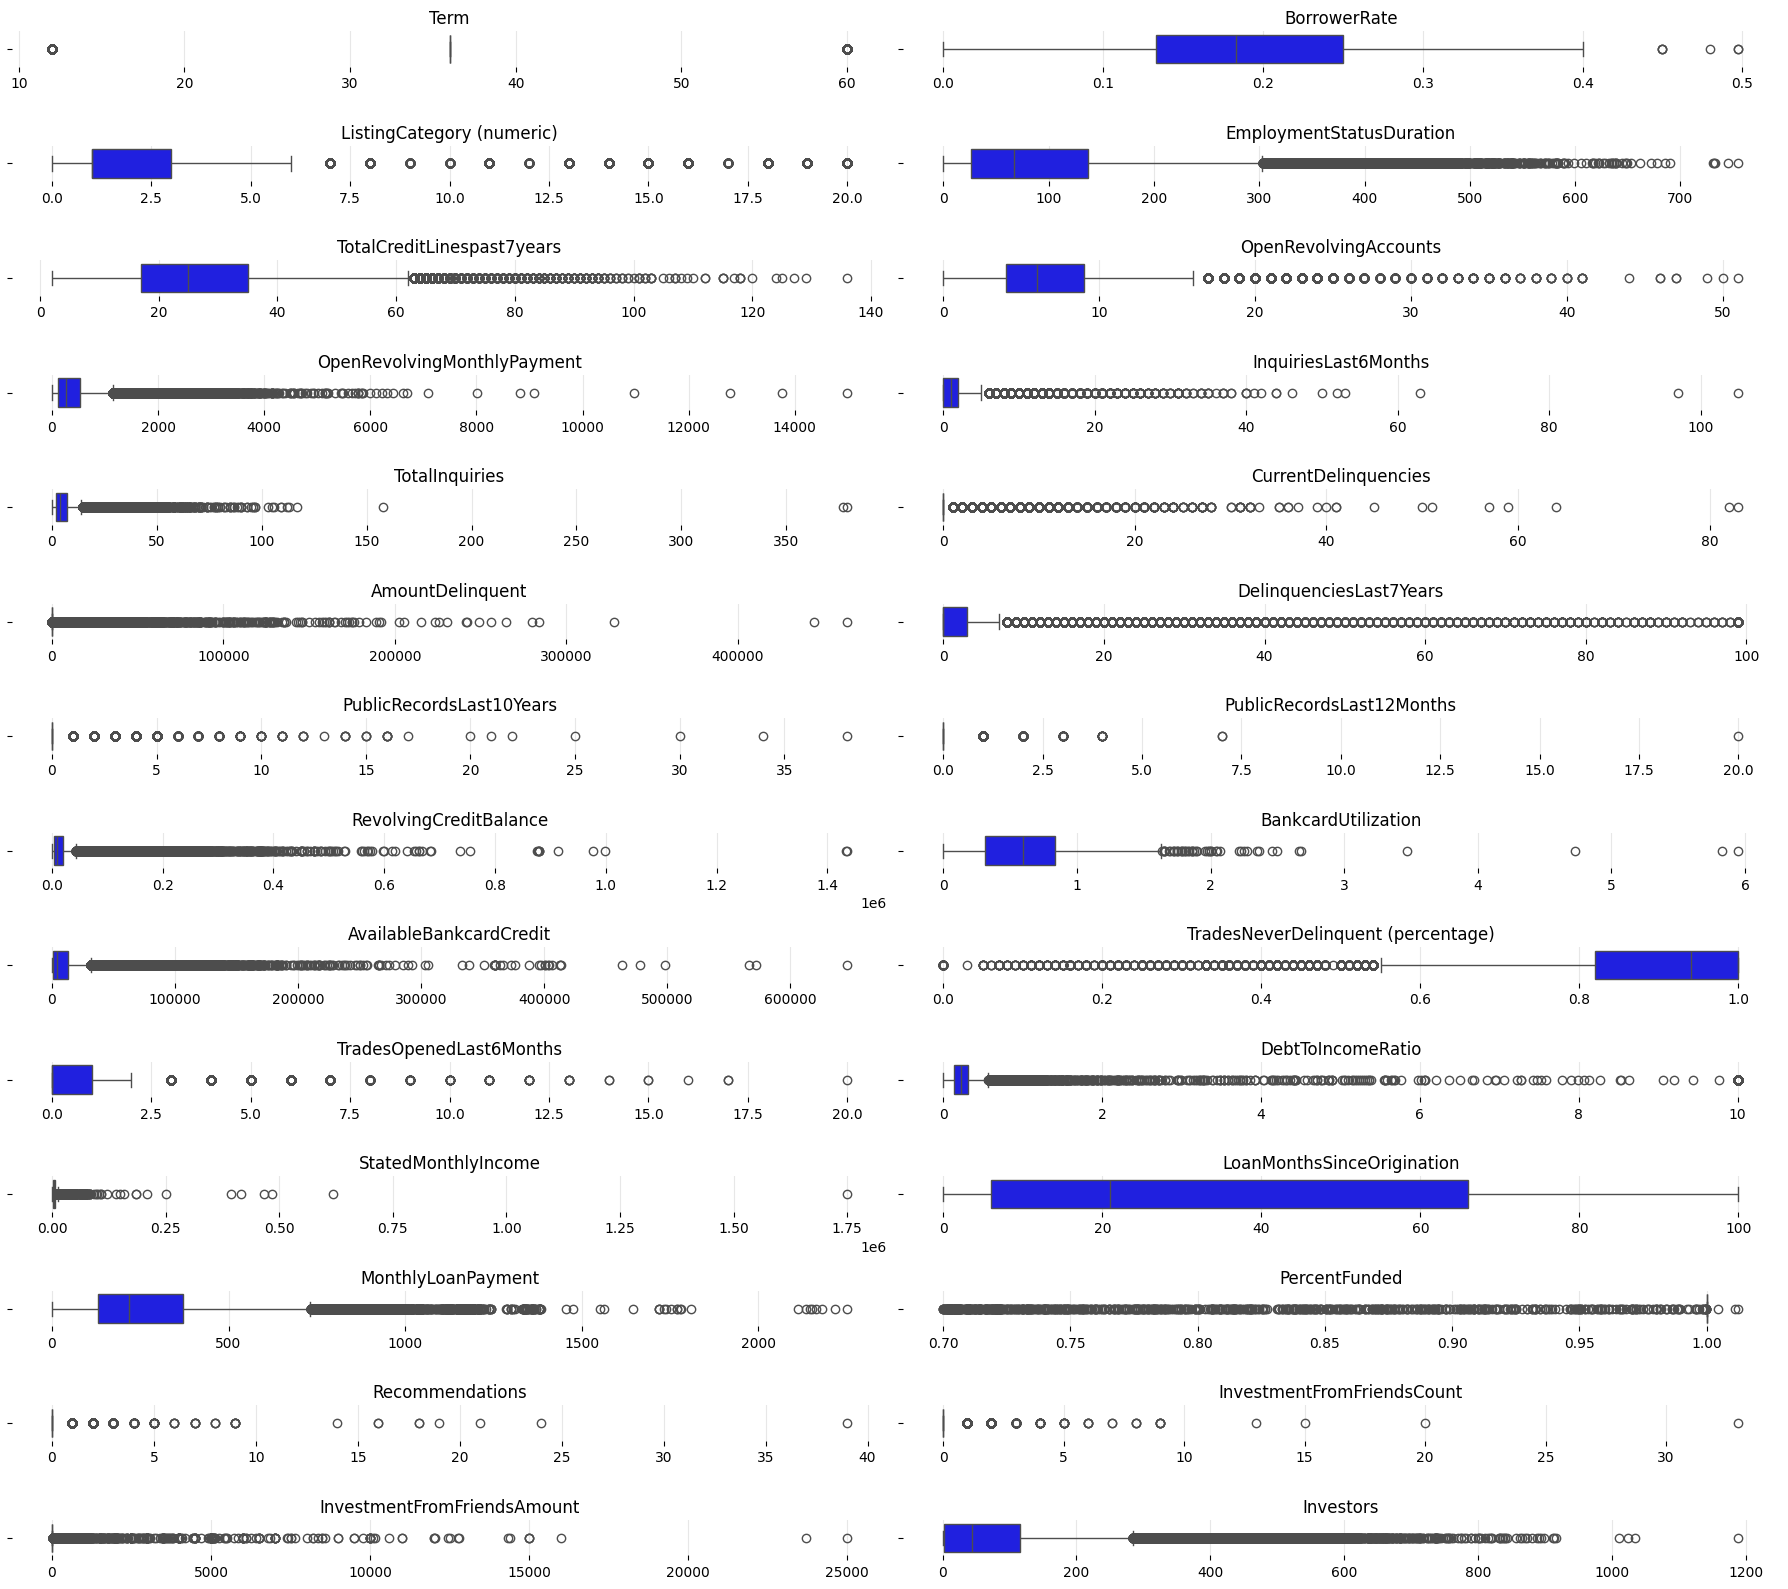

In [193]:
# Melt numerical variables into long format
temp = pd.melt(df[cols_numericals].reset_index(), id_vars="index", value_vars=cols_numericals)[["variable", "value"]]

ncols = 2
nrows = len(cols_numericals) // ncols + (len(cols_numericals) % ncols > 0)

plt.figure(figsize=(18, 16))
plt.subplots_adjust(hspace=0.8)

for i, variable in enumerate(cols_numericals):
    ax = plt.subplot(nrows, ncols, i + 1)

    sns.boxplot(
        data=temp[temp["variable"] == variable],
        x="value",
        color="blue",
        ax=ax
    )

    ax.set_title(variable, fontsize=12)
    ax.set_xlabel("")
    ax.grid(axis="x", alpha=0.3)

    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

In [194]:
#Remarque Amel : Trop de variables , peu lisible. A mettre apres le feature engineering peut-être.

## Outliers

In [195]:
#Remarque Amel : La gestion outlier doit venir juste apres le nettoyage, tout debut de l'EDA. Sinn les analyses sont faussées.

In [196]:
def is_outlier(df, column):
    Q1 = np.quantile(df[column], 0.25)
    Q3 = np.quantile(df[column], 0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"For variable {column}:")
    print(f"- Lower bound  = {lower_bound}")
    print(f"- Upper bound  = {upper_bound}")

    return ((df[column] < lower_bound) | (df[column] > upper_bound)).astype(int)


In [197]:
# 1 = outlier, 0 = normal
for col in cols_numericals:
    df[f"{col}_is_outlier"] = is_outlier(df, col)


print("\nOutlier counts per numerical variable\n")
for col in cols_numericals:
    print(f"{col}:")
    print(df[f"{col}_is_outlier"].value_counts(), "\n")

For variable Term:
- Lower bound  = 36.0
- Upper bound  = 36.0
For variable BorrowerRate:
- Lower bound  = -0.04150000000000001
- Upper bound  = 0.4249
For variable ListingCategory (numeric):
- Lower bound  = -2.0
- Upper bound  = 6.0
For variable EmploymentStatusDuration:
- Lower bound  = nan
- Upper bound  = nan
For variable TotalCreditLinespast7years:
- Lower bound  = nan
- Upper bound  = nan
For variable OpenRevolvingAccounts:
- Lower bound  = -3.5
- Upper bound  = 16.5
For variable OpenRevolvingMonthlyPayment:
- Lower bound  = -504.0
- Upper bound  = 1144.0
For variable InquiriesLast6Months:
- Lower bound  = nan
- Upper bound  = nan
For variable TotalInquiries:
- Lower bound  = nan
- Upper bound  = nan
For variable CurrentDelinquencies:
- Lower bound  = nan
- Upper bound  = nan
For variable AmountDelinquent:
- Lower bound  = nan
- Upper bound  = nan
For variable DelinquenciesLast7Years:
- Lower bound  = nan
- Upper bound  = nan
For variable PublicRecordsLast10Years:
- Lower bound 

In [198]:
#Remarque Amel : Ajouter la suppression des lignes outliers? Je vais les gerer dans la partie Feature Engineering.

# Bivariate Analysis 
- chi2 test
- barplot
- scatterplot

### Distribution of the target variable LoanStatus

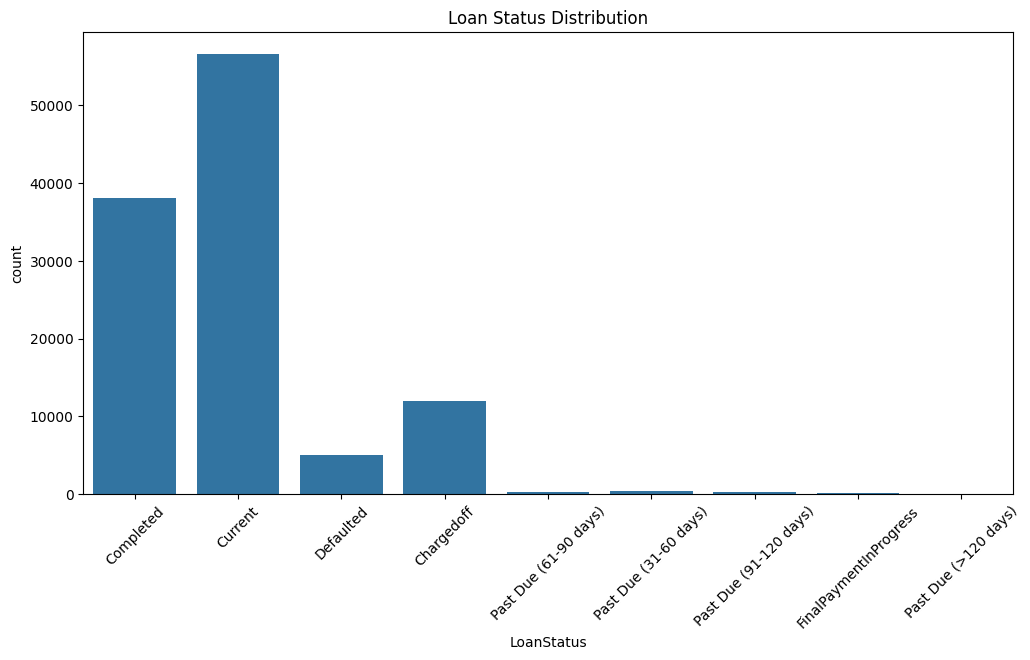

In [199]:
plt.figure(figsize=(12,6))
sns.countplot(x="LoanStatus", data=df)
plt.title("Loan Status Distribution")
plt.xticks(rotation=45)
plt.show()

In [200]:
#Remarque Amel, on va supprimer cette variable en amont de l'EDA. Elle n'a plus d'utilité.

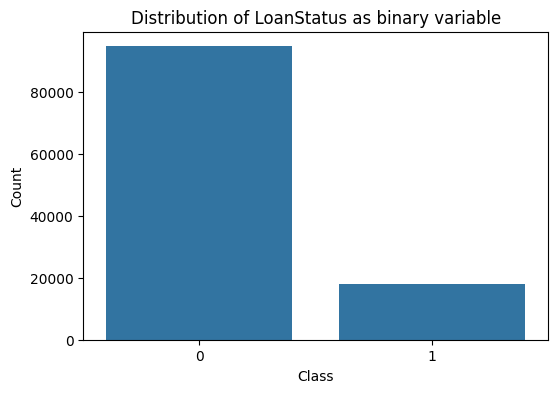

In [201]:
plt.figure(figsize=(6,4))
sns.countplot(x='LoanStatusBinaire', data=df)
plt.title("Distribution of LoanStatus as binary variable")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [202]:
(df["LoanStatusBinaire"].value_counts(normalize=True) * 100).round(2)

LoanStatusBinaire
0    84.05
1    15.95
Name: proportion, dtype: float64

The distribution of the binary Loan Status reveals a class imbalance, as 84% of loans are healthy (class 0 : Completed, Current, FinalPaymentInProgress), while only +-16% are defaulted (class 1 : Defaulted, Chargedoff, Past Due). This indicates that most borrowers repay their loans with only a minority falling into default. 

Overall, this distribution helps guide strategic decisions in risk management, product development, and personalized customer engagement.
Overall, analyzing this distribution allows for better risk management & customer segmentation, ultimately guiding strategic decisions related to credit counseling.

Although this imbalance is common in credit-risk datasets and was expected, we must handle it in the part dedicated to the **Feature Engineering**. 

### Sources used for EDA : 
- Dataset: https://www.kaggle.com/datasets/henryokam/prosper-loan-data/data
- Univariate Analysis: https://duchesnay.github.io/pystatsml/statistics/stat_univ.html
- Univariate Analysis & Outliers: practices during the lectures of M. Coulibaly
- Pandas: https://github.com/duchesnay/pystatsml/tree/master/data_manipulation
- Leakage Features: https://medium.com/@speaktoharisudhan/data-leakage-in-machine-leaning-c382b65f4c09
- EDA Examples: https://github.com/VenkyAdi/EDA---Projects/tree/main
- Correlation: https://www.rohan-paul.com/p/ml-interview-q-series-when-would-ff2
- Skewness & Kutrosis: https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis 
- Kurtosis: https://testbook.com/question-answer/a-distribution-that-is-abnormally-tall-and-peaked--5f68b23f59aa8ed6d2bce09b#:~:text=A%20normal%20distribution%20has%20a,to%20mesokurtic%20or%20platykurtic%20distributions.


 # Feature Engineering

In [203]:
#Remarque Amel : Feature Eng à mettre avant l'EDA ! Car suppression des colonnes "inutiles"--> Impact des visualisations. 
#Sur internet je vois que non. On fait que le feature engineering "structurel" das le nettoyage , c'est ce que Juan à fait. 

1. IMPUTATION DES VALEURS MANQUANTES.

Concernant les outliers:
Dans les modèles de risque, les outliers portent souvent une information précieuse (dépassements de dettes, delinquencies multiples, revenus extrêmes).
Plutôt que de les supprimer ou de les remplacer, nous conservons la valeur originale et créons une variable indicatrice (_is_outlier).
Cette approche permet au modèle de capter le comportement extrême sans déformer la distribution.

In [204]:
# Pourcentage total de NaN par année d'octroi du crédit

# Extraire l'année d'origination
df["OriginationYear"] = df["LoanOriginationDate"].dt.year

# Calcul du pourcentage de NA par année
nan_pct_by_year = (
    df.groupby("OriginationYear")
      .apply(lambda x: x.isna().mean().mean() * 100)
      .round(2)
)

print("Pourcentage total de NaN par année (toutes colonnes confondues) :")
nan_pct_by_year


Pourcentage total de NaN par année (toutes colonnes confondues) :


C:\Users\cherb\AppData\Local\Temp\ipykernel_5600\4121027598.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.isna().mean().mean() * 100)


OriginationYear
2005    26.39
2006    14.21
2007     1.99
2008     0.12
2009     0.14
2010     0.17
2011     0.16
2012     0.15
2013     0.12
2014     0.18
dtype: float64

In [205]:
# Extraire l'année si ce n'est pas déjà fait
df["OriginationYear"] = df["LoanOriginationDate"].dt.year

# Nombre total de lignes avant suppression
total_rows = len(df)

# Filtre : garder uniquement les années > 2007
df = df[df["OriginationYear"] > 2007]
df = df[df["OriginationYear"] > 2007]
# Nombre de lignes après suppression
remaining_rows = len(df)

print("Nombre total de lignes avant :", total_rows)
print("Nombre de lignes restantes après retrait de 2007 et avant :", remaining_rows)
print("Nombre de lignes supprimées :", total_rows - remaining_rows)


Nombre total de lignes avant : 112861
Nombre de lignes restantes après retrait de 2007 et avant : 95477
Nombre de lignes supprimées : 17384


Concentration des NA sur les années antérieures. Suppression car mauvaise collecte + style de vie différent de aujourd'hui. 

In [206]:
# --- Missing Values by LoanStatus (percentages only) ---

# Colonnes contenant au moins 1 NA
cols_with_na = df.columns[df.isna().sum() > 0]

# Nombre de NA par colonne selon LoanStatus (intermédiaire)
na_counts = (
    df.groupby("LoanStatus")[cols_with_na]
      .apply(lambda x: x.isna().sum())
      .T
)

# Tableau final avec uniquement les %
na_pct = pd.DataFrame(index=na_counts.index)

# Pourcentages par LoanStatus
for status in df["LoanStatus"].unique():
    na_pct[f"{status}_pct"] = (
        na_counts[status] / df[df["LoanStatus"] == status].shape[0] * 100
    ).round(2)

# Pourcentage global
na_pct["Total_pct"] = (
    df[cols_with_na].isna().sum() / len(df) * 100
).round(2)

# Trier par pourcentage total décroissant
na_pct = na_pct.sort_values("Total_pct", ascending=False)

print("Nombre de colonnes avec NA > 1 :", (df.isna().sum() > 1).sum())
na_pct



Nombre de colonnes avec NA > 1 : 12


,Current_pct,Defaulted_pct,Completed_pct,Chargedoff_pct,Past Due (61-90 days)_pct,Past Due (31-60 days)_pct,Past Due (91-120 days)_pct,FinalPaymentInProgress_pct,Past Due (>120 days)_pct,Total_pct
DebtToIncomeRatio,7.24,9.52,9.23,14.22,12.14,9.92,8.88,7.80,12.5,8.49
Occupation,2.30,0.00,0.05,0.00,0.00,1.38,0.00,0.98,0.0,1.39
ListingCreationDate,0.33,0.29,0.33,0.37,1.60,0.28,0.00,0.98,0.0,0.34
BorrowerState,0.00,0.05,0.09,0.07,0.00,0.00,0.00,0.00,0.0,0.03
EmploymentStatusDuration,0.02,0.05,0.04,0.02,0.00,0.00,0.00,0.00,0.0,0.02
FirstRecordedCreditLine,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.0,0.01
TotalCreditLinespast7years,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.0,0.01
InquiriesLast6Months,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.0,0.01
CurrentDelinquencies,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.0,0.01
AmountDelinquent,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.0,0.01


In [207]:
# Définition des groupes de variables à imputer
num_vars = [
    "DebtToIncomeRatio", "EmploymentStatusDuration", "TotalCreditLinespast7years",
    "InquiriesLast6Months", "CurrentDelinquencies", "AmountDelinquent",
    "DelinquenciesLast7Years", "PublicRecordsLast10Years"
]

cat_vars = ["BorrowerState"]   # mode
high_card_vars = ["Occupation"]  # Unknown

date_vars = ["ListingCreationDate", "FirstRecordedCreditLine"]


In [208]:
def compare_distribution_before_after(df_before, df_after, col, bins=40):
    plt.figure(figsize=(12,5))

    # Avant imputation
    plt.subplot(1,2,1)
    sns.histplot(df_before[col], bins=bins, kde=True, color="steelblue")
    plt.title(f"Avant imputation : {col}")
    
    # Après imputation
    plt.subplot(1,2,2)
    sns.histplot(df_after[col], bins=bins, kde=True, color="seagreen")
    plt.title(f"Après imputation : {col}")

    plt.tight_layout()
    plt.show()


IMPUTATION : Numériques → médiane (+ flag pour DTI)

---- DebtToIncomeRatio ----


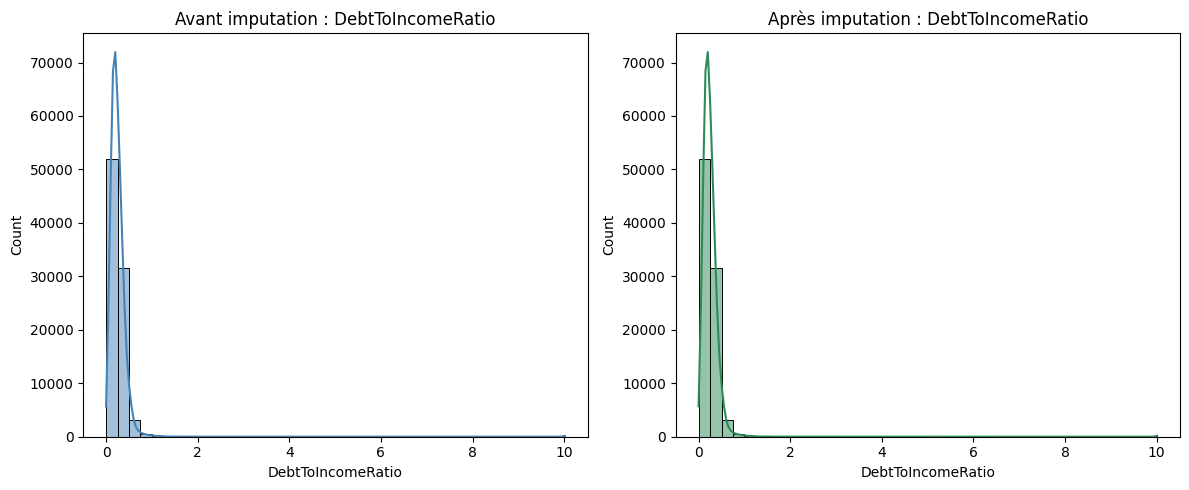

---- EmploymentStatusDuration ----


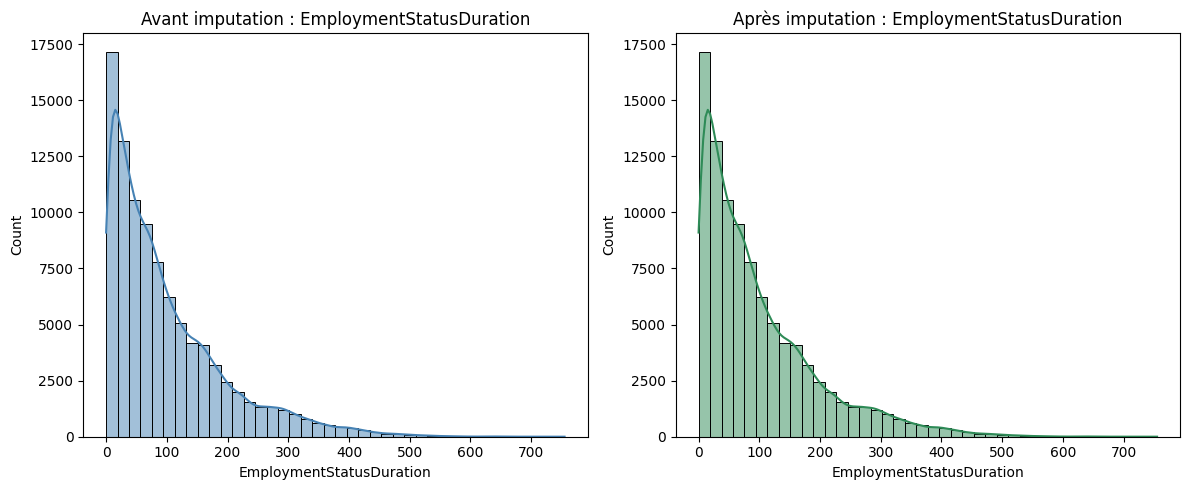

---- TotalCreditLinespast7years ----


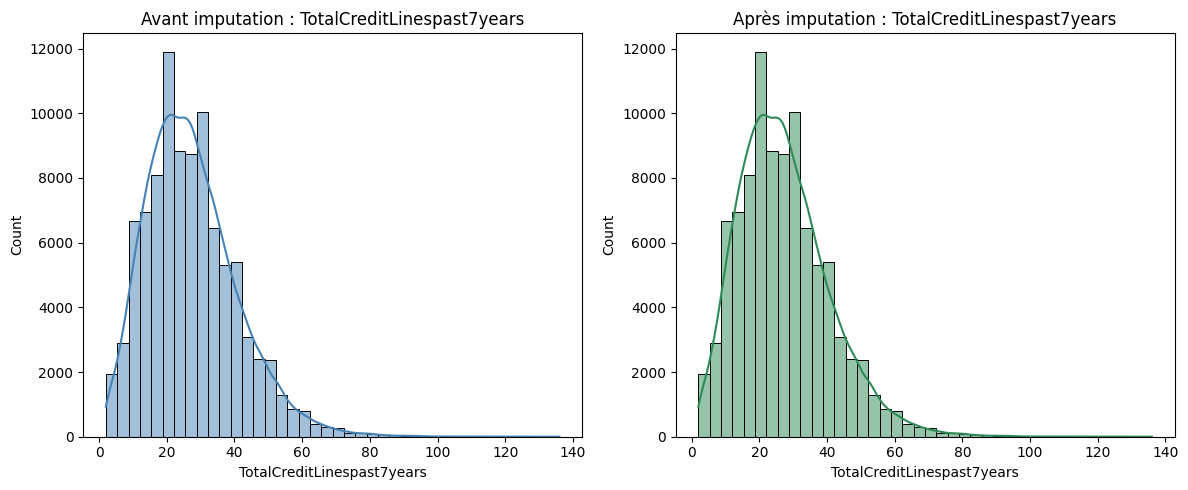

---- InquiriesLast6Months ----


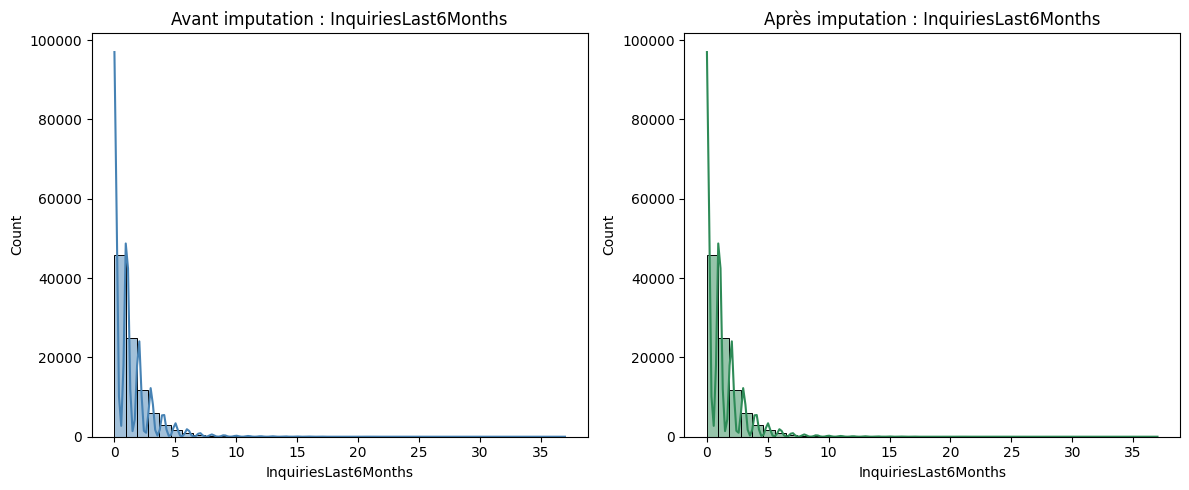

---- CurrentDelinquencies ----


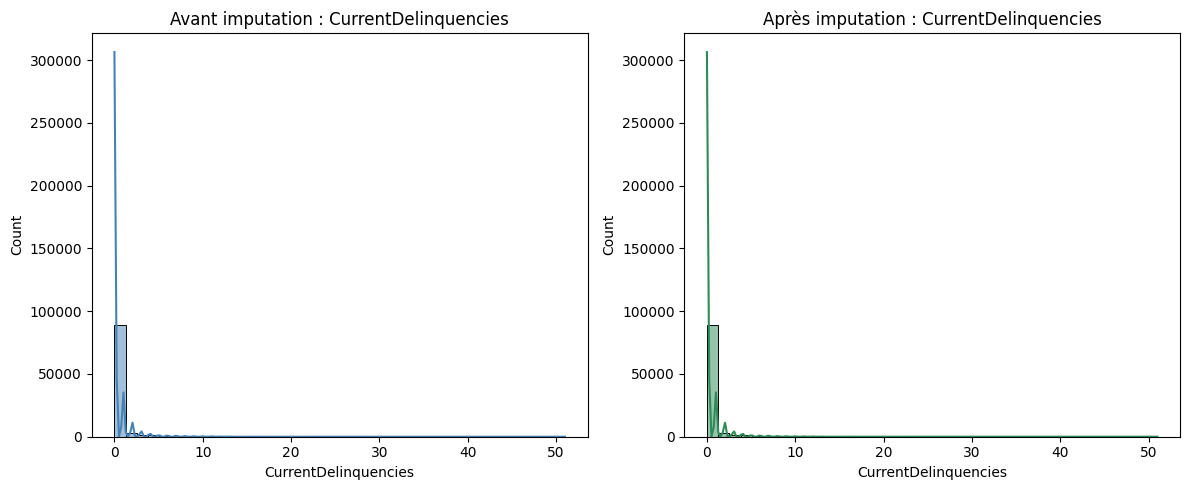

---- AmountDelinquent ----


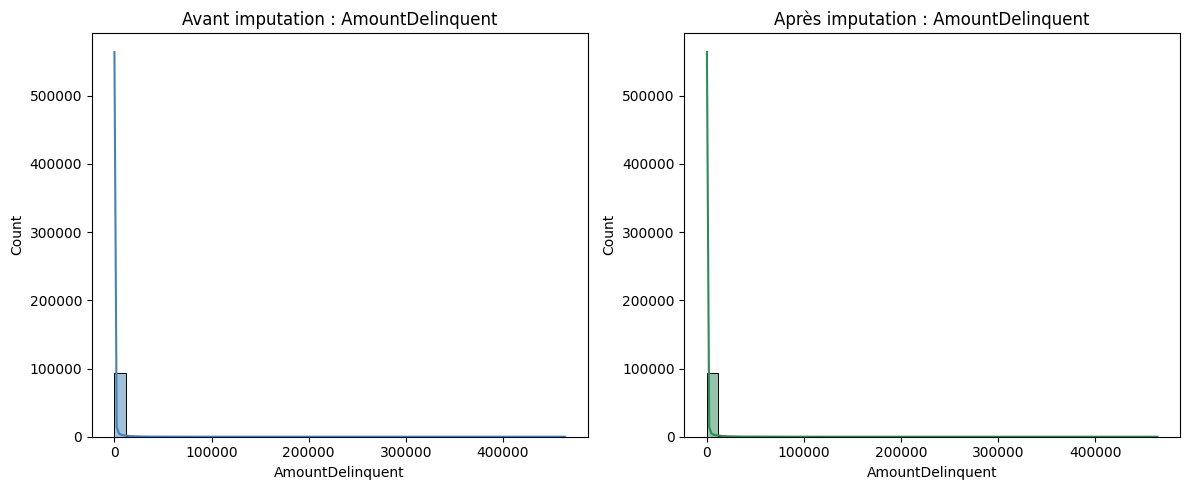

---- DelinquenciesLast7Years ----


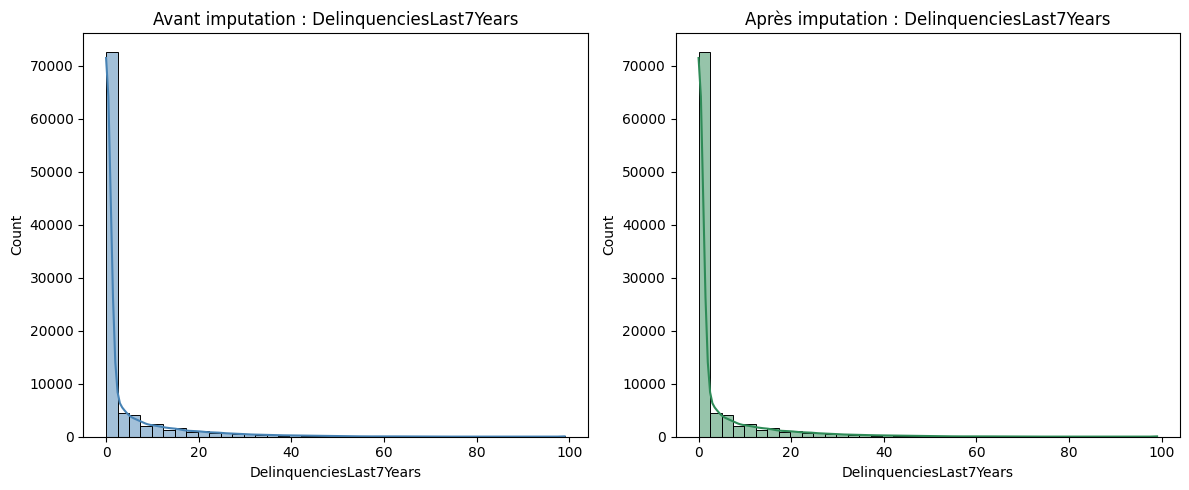

---- PublicRecordsLast10Years ----


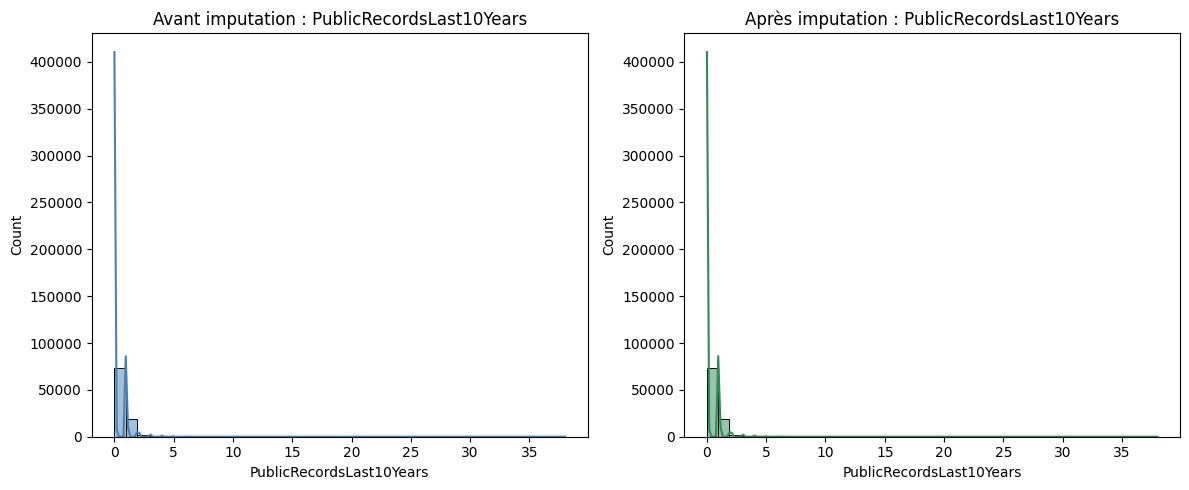

In [209]:
df_imputed = df.copy()

for col in num_vars:
    print(f"---- {col} ----")
    
    # Visualisation AVANT
    compare_distribution_before_after(df, df_imputed, col)

    # Flag uniquement pour DebtToIncomeRatio
    if col == "DebtToIncomeRatio":
        df_imputed[col + "_missing"] = df[col].isna().astype(int)

    # Imputation médiane
    median_value = df[col].median()
    df_imputed[col] = df[col].fillna(median_value)


#REFAIRE LES GRAPHES (sont laids)

IMPUTATION : Catégorielles (faible cardinalité) → Mode

In [210]:
for col in cat_vars:
    print(f"---- {col} ----")
    print(df[col].value_counts(dropna=False).head())

    mode_val = df[col].mode()[0]
    df_imputed[col] = df[col].fillna(mode_val)


---- BorrowerState ----
BorrowerState
CA    12386
NY     6265
FL     6095
TX     5781
IL     4980
Name: count, dtype: int64


IMPUTATION : Catégories high-cardinality → “Unknown”

In [211]:
for col in high_card_vars:
    print(f"---- {col} ----")
    df_imputed[col] = df[col].fillna("Unknown")


---- Occupation ----


IMPUTATION : Dates → Transformer + Imputer

In [212]:
# Exemple : transformer en année
for col in date_vars:
    df[col + "_year"] = df[col].dt.year
    df_imputed[col + "_year"] = df_imputed[col].dt.year

    # # Visualisation avant/après
    # compare_distribution_before_after(df, df_imputed, col + "_year")

    # Imputation médiane
    median_year = df_imputed[col + "_year"].median()
    df_imputed[col + "_year"] = df_imputed[col + "_year"].fillna(median_year)


df_imputed = df_imputed.drop(columns=date_vars)


4.2. Création de nouvelles variables

1 — DebtPaymentRatio

In [213]:
df_imputed["DebtPaymentRatio"] = (
    df_imputed["MonthlyLoanPayment"] / df_imputed["StatedMonthlyIncome"]
).replace([np.inf, -np.inf], np.nan)


2 — BadHistoryFlag

In [214]:
df_imputed["BadHistoryFlag"] = (
    (df_imputed["CurrentDelinquencies"] > 0) |
    (df_imputed["DelinquenciesLast7Years"] > 2) |
    (df_imputed["PublicRecordsLast10Years"] > 0) |
    (df_imputed["InquiriesLast6Months"] > 5)
).astype(int)

3 — RevolvingUtilization & StressIndex

In [215]:
df_imputed["RevolvingUtilization"] = (
    df_imputed["RevolvingCreditBalance"] /
    (df_imputed["RevolvingCreditBalance"] + df_imputed["AvailableBankcardCredit"])
).replace([np.inf, -np.inf], np.nan)

df_imputed["RevolvingStressIndex"] = (
    0.5 * df_imputed["RevolvingUtilization"] +
    0.5 * df_imputed["BankcardUtilization"]
)

4.3. Encoding

Catégorielles nominales → One Hot (Occupation, State…)

Ordinales → OrdinalEncoder (IncomeRange, EmploymentStatus si ordonné)

Binary → rien, déjà OK

In [222]:
#Les types de variables 
nominal_vars = [
    "BorrowerState",
    "Occupation",
    "EmploymentStatus",
    "ListingCategory (numeric)"
]

ordinal_vars = ["IncomeRange"]

binary_vars = [
    "IsBorrowerHomeowner",
    "CurrentlyInGroup",
    "IncomeVerifiable",
    "LoanStatusBinaire"
]

# Tous les autres seront numériques
num_vars = df_imputed.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_vars = [col for col in num_vars if col not in binary_vars]

In [ ]:
#Ordonner les modalités de la variable IncomeRange
df_imputed["IncomeRange"] = df_imputed["IncomeRange"].replace("Not employed", "$0")

income_order = [
    '$0',
    '$1-24,999',
    '$25,000-49,999',
    '$50,000-74,999',
    '$75,000-99,999',
    '$100,000+'
]

ordinal_encoder = OrdinalEncoder(categories=[income_order])


In [ ]:

onehot_encoder = OneHotEncoder(drop="first",handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("nominal", onehot_encoder, nominal_vars),
        ("ordinal", ordinal_encoder, ordinal_vars),
        ("numeric", "passthrough", num_vars),
        ("binary", "passthrough", binary_vars)
    ]
)

In [225]:
df_encoded = preprocessor.fit_transform(df_imputed)

# Convertir en DataFrame propre
encoded_columns = (
    preprocessor.named_transformers_["nominal"].get_feature_names_out(nominal_vars)
    .tolist()
)

df_final = pd.DataFrame(
    df_encoded,
    columns=encoded_columns + ordinal_vars + num_vars + binary_vars
)

df_final.shape


(95477, 186)

Les variables très manquantes (>20%) ont déjà été retirées.

Les variables générant du data leakage (paiements, pertes, retards réels, recouvrements) ont été supprimées.

Les variables fortement corrélées ou redondantes ont été fusionnées ou éliminées (APR/Rate, scores, lignes de crédit…).

Les variables restantes ont un taux de NA faible, sont cohérentes, et apportent toutes une information pertinente pour prédire le défaut.

4.4. Scaling

Seulement pour modèles sensibles (LR, SVM, KNN) :

StandardScaler sur les variables continues

4.5. Train-test split

Stratified split (à cause de class imbalance)

4.6. Handling imbalance

SMOTE OU class_weight="balanced"

On teste les deux, mais on applique après le split.


### On selectionne les principales colonnes d'intérêt pour la modelisation

- **CreditGrade** : The credit rating that was assigned at the time the listing went live. Applicable for listings pre-2009 period and will only be populated for those listings.
- **Term** : The length of the loan expressed in months.
- **BorrowerAPR** : The borrower's Annual Percentage Rate (APR) for the loan. **(Pour la modélisation, le BorrowerAPR est plus pertinent que le BorrowerRate, car il reflète le coût réel du crédit en intégrant les frais, offrant ainsi une mesure plus complète et comparable du risque d’emprunt.)**
- **ProsperRating (numeric)** : The Prosper Rating assigned at the time the listing was created:  
  `0 = N/A, 1 = HR, 2 = E, 3 = D, 4 = C, 5 = B, 6 = A, 7 = AA.`  

- **ProsperScore** : A custom risk score built using historical Prosper data. Score ranges from 1–10, with **10 being the best** (lowest risk). Applicable for loans originated after July 2009.

- **ListingCategory** : The category of the listing selected by the borrower when posting their listing:  
  `0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7 - Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans`

  - **BorrowerState** : The two-letter abbreviation of the borrower’s state at the time the listing was created.

- **Occupation** : The occupation selected by the borrower at the time they created the listing.

- **EmploymentStatus** : The employment status of the borrower at the time they posted the listing.

- **EmploymentStatusDuration** : The length (in months) of the employment status at the time the listing was created.

- **IsBorrowerHomeowner** : Indicates whether the borrower is a homeowner (based on mortgage or documentation confirming homeownership).
- **CurrentCreditLines** : Number of current credit lines at the time the credit profile was pulled.






🔴 5. Modélisation

Baseline : Logistic Regression

Pour Logistic Regression, KNN, SVM :

👉 ces modèles sont sensibles aux outliers.
df["col_winsorized"] = df["col"].clip(lower_bound, upper_bound)

Mais uniquement pour les modèles linéaires.



Modèles :

RandomForest

XGBoost

LightGBM

Évaluation :

ROC AUC --> Mesure la qualité la direction de séparation entre les deux classes

(Gini = 2*AUC - 1 ) ? Utile ? 

Confusion matrix --> Interessant 

Surtout la BALANCED ACCURACY (le prof en a bcp parlé) --> Qualité du "seuil" qui sépare les deux catégories. 

Recall class 1 (important en risk)

🟤 6. Feature Importance

Permutation importance

SHAP (optionnel)

⚫ 7. Conclusion

Résumé

Feature les plus importantes

Limites

Étapes suivantes  --> Prédire une autres vaariabes comme celle du temps à laquelle les "current " tomberont en defaut ? 